# Subgroup Analyses
### <i>[Public Release]</i>
### Rohan Satya Isaac

---

## Table of Contents

- 0. Data Preparation
- 1. Calculating Performance Metrics & Statistical Significance Testing for Subgroups
  - Performance Evaluation Metrics
  - Statistical Tests
- 2. Screening & Pathology Outcomes
- 3. Pathology Subtypes Distribution
- 4. BIRADS Descriptor Outcomes
  - 4.1 Mass Shape
  - 4.2 Asymmetry
  - 4.3 Architectural Distortion
  - 4.4 Mass Margins
  - 4.5 Calcification Findings
  - 4.6 Calcication Distribution
- 5. Distribution by Finding Characteristics
  - 5.1 Mass
  - 5.2 Asymmetry
  - 5.3 Arch Distortion
  - 5.4 Calcification
  - 5.5 Stitch Finding Characteristics Figures
- 6. False Negatives - Failure Analyses
- Misc : Finding Permutations; BIRADS 0 Distribution

---

In [2]:
import re
from tqdm import tqdm
from itertools import combinations
from dotenv import load_dotenv # this is only used in this example to load filepaths from a .env file!

import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, roc_curve

import scipy.stats as st
from scipy.stats import norm
from scipy.stats import gaussian_kde, kruskal, mannwhitneyu, norm

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import PathPatch

from utils import (
    compute_metrics,
    bootstrap_group_aucs,
    kruskal_test_on_aucs,
    perform_one_vs_each_auc_tests,
    pairwise_permutation_test,
    apply_bonferroni_correction_groupwise,
    bootstrap_partial_overlap_auc_test,
)

from constants import (
    scr_det_cancer, scr_det_cancer_n,
    bx_prov_benign, bx_prov_benign_n,
    category_colors_map, outcome_categories_list,
    calfind_labels, massmargin_map, calcdistri_mapping,
    massshape_mapping, severity_labels,
    tissueden_br_map, key_order,
    pathology_labels, non_inv_cancer,
    non_inv_cancer_n
)

# =========
# model cutoff
cutoff = 0.1
# =========

# output folders
basepath_for_images = r'../outputs/figures/'
basepath_for_tables = r'/opt/NAS3/mammo/lunit/data/'

WRITE_OUTPUT = False

### 0. Data Preparation

In [3]:
# in this example I'll be loading my filepaths from a .env file with the dotenv package
# but these should be changed as needed
load_dotenv()

# paths to exam and finding level data
exam_level_path = os.environ['EXAM_LEVEL_PATH']
finding_level_path = os.environ['FINDING_LEVEL_PATH']

mag_exam_level_df = pd.read_csv(exam_level_path)
mag_df = pd.read_csv(finding_level_path)

mag_df['empi_anon'] = pd.to_numeric(mag_df['empi_anon'])
mag_df['acc_anon'] = pd.to_numeric(mag_df['acc_anon'])

mag_exam_level_df['empi_anon'] = pd.to_numeric(mag_exam_level_df['empi_anon'])
mag_exam_level_df['acc_anon'] = pd.to_numeric(mag_exam_level_df['acc_anon'])

# copy of columns for figure presentation purposes
mag_df['outcome_type'] = mag_df['label']
mag_df['exam_pathology'] = mag_df['scr_detected_path']

mag_exam_level_df['outcome_type'] = mag_exam_level_df['label']
mag_exam_level_df['exam_pathology'] = mag_exam_level_df['scr_detected_path']

# keep a copy and preprocess copied dataframe
lunit_mag_df = mag_df.copy()
lunit_mag_exam_level_df = mag_exam_level_df.copy()

/tmp/ipykernel_2235176/3026511092.py:6: DtypeWarning: Columns (61,65,74,75,76,82,83,84,85,87,109,110,111,113,129,143) have mixed types. Specify dtype option on import or set low_memory=False.
  mag_df = pd.read_csv(finding_level_path)


In [4]:
### Data Preparation for Exam Level and Finding Level dataframe ###
# create a copy of screen detected path column for figure presentation purposes 
lunit_mag_df['exam_pathology'] = lunit_mag_df['scr_detected_path']

# create numeric level pathology columns
lunit_mag_df['exam_pathology_numeric'] = lunit_mag_df.exam_pathology.replace({'No Pathology': np.nan,
                                                                             'Invasive Cancer':0,
                                                                             'High Risk Lesion':2,
                                                                             'Benign Lesion':4,
                                                                             'Noninvasive Cancer':1,
                                                                             'Borderline Lesion':3})

lunit_mag_exam_level_df['exam_pathology_numeric'] = lunit_mag_exam_level_df.exam_pathology.replace({'No Pathology': np.nan,
                                                                                                     'Invasive Cancer':0,
                                                                                                     'High Risk Lesion':2,
                                                                                                     'Benign Lesion':4,
                                                                                                     'Noninvasive Cancer':1,
                                                                                                     'Borderline Lesion':3})

# add new line characters for exam pathology for word wrapping in  figures 
lunit_mag_df.exam_pathology = lunit_mag_df.exam_pathology.replace({'No Pathology':'No\nPathology',
                                                                   'Invasive Cancer':'Invasive\nCancer',
                                                                   'High Risk Lesion':'High Risk\nLesion',
                                                                   'Benign Lesion':'Benign\nLesion',
                                                                   'Noninvasive Cancer':non_inv_cancer_n, # a variable because the name was changed to DCIS
                                                                   'Borderline Lesion':'Borderline\nLesion'})

lunit_mag_exam_level_df.exam_pathology = lunit_mag_exam_level_df.exam_pathology.replace({'No Pathology':'No\nPathology',
                                                                                         'Invasive Cancer':'Invasive\nCancer',
                                                                                         'High Risk Lesion':'High Risk\nLesion',
                                                                                         'Benign Lesion':'Benign\nLesion',
                                                                                         'Noninvasive Cancer':non_inv_cancer_n,
                                                                                         'Borderline Lesion':'Borderline\nLesion'})

# update label names for figures
lunit_mag_df.outcome_type = lunit_mag_df.outcome_type.replace({"Screen Detected Cancer":scr_det_cancer, "Biopsy Proven Benign":bx_prov_benign})
lunit_mag_exam_level_df.outcome_type = lunit_mag_exam_level_df.outcome_type.replace({"Screen Detected Cancer":scr_det_cancer, "Biopsy Proven Benign":bx_prov_benign})

# create a binary label for exam pathology
lunit_mag_df['exam_pathology_binary'] = 0
lunit_mag_df.loc[lunit_mag_df.outcome_type == scr_det_cancer, 'exam_pathology_binary'] = 1
lunit_mag_df.loc[lunit_mag_df.outcome_type == "Interval Cancer", 'exam_pathology_binary'] = np.nan

lunit_mag_exam_level_df['exam_pathology_binary'] = 0
lunit_mag_exam_level_df.loc[lunit_mag_exam_level_df.outcome_type == scr_det_cancer, 'exam_pathology_binary'] = 1
lunit_mag_exam_level_df.loc[lunit_mag_exam_level_df.outcome_type == "Interval Cancer", 'exam_pathology_binary'] = np.nan

# create dataframes that do not have interval cancers and assign order for figure
lunit_mag_df_temp = lunit_mag_df[lunit_mag_df['outcome_type'].isin(['Screen Negative', 'Diagnostic Negative', bx_prov_benign, scr_det_cancer])]
custom_order = ['Screen Negative', 'Diagnostic Negative', bx_prov_benign, scr_det_cancer]
# Convert outcome_type to a categorical type with the specified order
lunit_mag_df_temp['outcome_type'] = pd.Categorical(lunit_mag_df_temp['outcome_type'], categories=custom_order, ordered=True)

lunit_mag_exam_level_df_temp = lunit_mag_exam_level_df[lunit_mag_exam_level_df['outcome_type'].isin(['Screen Negative', 'Diagnostic Negative', bx_prov_benign, scr_det_cancer])]
custom_order = ['Screen Negative', 'Diagnostic Negative', bx_prov_benign, scr_det_cancer]
# Convert outcome_type to a categorical type with the specified order
lunit_mag_exam_level_df_temp['outcome_type'] = pd.Categorical(lunit_mag_exam_level_df_temp['outcome_type'], categories=custom_order, ordered=True)

/tmp/ipykernel_2235176/1179470016.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lunit_mag_df['exam_pathology_numeric'] = lunit_mag_df.exam_pathology.replace({'No Pathology': np.nan,
/tmp/ipykernel_2235176/1179470016.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lunit_mag_exam_level_df['exam_pathology_numeric'] = lunit_mag_exam_level_df.exam_pathology.replace({'No Pathology': np.nan,
/tmp/ipykernel_2235176/1179470016.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [5]:
# plug exam level dataframe
lunit_mag_df_dedup = lunit_mag_exam_level_df_temp.copy()
lunit_mag_df_AB_dedup_acc_temp = lunit_mag_exam_level_df_temp.copy()

# plug finding level dataframe
lunit_mag_df_AB_dedup = lunit_mag_df_temp[lunit_mag_df_temp.asses != "N"]

---

### 1. Calculating Performance Metrics & Statistical Significance Testing for Subgroups (Demographics, Breast Density, Pathological Outcome, Finding Characteristics)

In [6]:
df = lunit_mag_exam_level_df.copy()

# remove interval cancers for the analysis
df = df[df.outcome_type != "Interval Cancer"]

# replace labels with their values
df.tissueden = df.tissueden.replace(tissueden_br_map)

# a new label for evaluating on all data
df['all'] = 'all'

# labels for invasive cancer and non-invasive cancer (DCIS) evaluation
df['Invasive Cancer'] = 'Invasive Cancer'
df.loc[df.exam_pathology == non_inv_cancer_n, 'Invasive Cancer'] = np.nan

df['Noninvasive Cancer'] = 'Noninvasive Cancer'
df.loc[df.exam_pathology == "Invasive\nCancer", 'Noninvasive Cancer'] = np.nan

#### Performance Evaluation Metrics

In [7]:
group_columns = ['all','race', 'ethnicity', 'tissueden', 'age_binned','Invasive Cancer', 'Noninvasive Cancer', 'exam_mass', 'exam_asymmetry', 'exam_arch_distortion', 'exam_calcification']

results = []

# Loop through each column and calculate metrics for each unique value in that column
for col in group_columns:
    print('---', col, '---')
    for value in df[col].unique():
        if col == 'tissueden' and value == 5:
            continue
        
        print(value)
        group_df = df[df[col] == value]
        
        # Compute metrics
        metrics = compute_metrics(group_df)
        
        # Get total for percentages
        total = metrics['total_label_0'] + metrics['total_label_1']
        
        # Ensure total is not zero to avoid division by zero
        if total == 0:
            total = np.nan
        
        # Add both whole numbers and percentages for tn, fp, fn, tp
        metrics['tn_count'] = f"{metrics['tn']} ({(metrics['tn'] / total * 100):.2f}%)" if not np.isnan(metrics['tn']) else np.nan
        metrics['fp_count'] = f"{metrics['fp']} ({(metrics['fp'] / total * 100):.2f}%)" if not np.isnan(metrics['fp']) else np.nan
        metrics['fn_count'] = f"{metrics['fn']} ({(metrics['fn'] / total * 100):.2f}%)" if not np.isnan(metrics['fn']) else np.nan
        metrics['tp_count'] = f"{metrics['tp']} ({(metrics['tp'] / total * 100):.2f}%)" if not np.isnan(metrics['tp']) else np.nan
        
        # Add total_label_0 (tn + fp) and total_label_1 (fn + tp) with counts and percentages
        total_label_0_count = metrics['tn'] + metrics['fp'] if not np.isnan(metrics['tn']) and not np.isnan(metrics['fp']) else np.nan
        total_label_1_count = metrics['fn'] + metrics['tp'] if not np.isnan(metrics['fn']) and not np.isnan(metrics['tp']) else np.nan
        
        metrics['total_label_0_count'] = f"{total_label_0_count} ({(total_label_0_count / total * 100):.2f}%)" if not np.isnan(total_label_0_count) else np.nan
        metrics['total_label_1_count'] = f"{total_label_1_count} ({(total_label_1_count / total * 100):.2f}%)" if not np.isnan(total_label_1_count) else np.nan
        
        # Remove the raw counts as they are now included in the formatted strings
        metrics.pop('tn')
        metrics.pop('fp')
        metrics.pop('fn')
        metrics.pop('tp')
        
        # Add the group column name and value as separate entries
        metrics.update({'group_value': value, 'group_type': col})
        results.append(metrics)

# Convert results to DataFrame
metrics_df = pd.DataFrame(results)

# Rearrange columns to have 'group_value' and 'group_type' at the beginning
cols = ['group_type', 'group_value'] + [col for col in metrics_df.columns if col not in ['group_type', 'group_value']]
metrics_df = metrics_df[cols]

--- all ---
all
--- race ---
Black
White
Unknown
Asian
Other
--- ethnicity ---
Not Hispanic or Latino
Unknown
Hispanic or Latino
--- tissueden ---
B
C
<50
>=75
--- Invasive Cancer ---
Invasive Cancer
nan
--- Noninvasive Cancer ---
Noninvasive Cancer
nan
--- exam_mass ---
0.0
1.0
--- exam_asymmetry ---
1.0
0.0
--- exam_arch_distortion ---
0.0
1.0
--- exam_calcification ---
0.0
1.0


In [8]:
metrics_df.group_type = metrics_df.group_type.replace({"race":"Race",
                              "ethnicity":"Ethnicity",
                              "tissueden":"Tissue Density",
                              "age_binned":"Age Group",
                              "Invasive Cancer":"Pathological Outcome",
                              "Noninvasive Cancer":"Pathological Outcome",
                              "exam_mass":"Mass",
                              "exam_asymmetry":"Asymmetry",
                              "exam_arch_distortion":"Architectural Distortion",
                              "exam_calcification":"Calcification",
                              "all":"Overall"})

metrics_df.group_value = metrics_df.group_value.astype(str)

# provide label names
metrics_df.loc[(metrics_df.group_type == "Mass") & (metrics_df.group_value == "1.0"), 'group_value'] = "Mass"
metrics_df.loc[(metrics_df.group_type == "Asymmetry") & (metrics_df.group_value == "1.0"), 'group_value'] = "Asymmetry"
metrics_df.loc[(metrics_df.group_type == "Architectural Distortion") & (metrics_df.group_value == "1.0"), 'group_value'] = "Architectural Distortion"
metrics_df.loc[(metrics_df.group_type == "Calcification") & (metrics_df.group_value == "1.0"), 'group_value'] = "Calcification"

# filter invalid group values
metrics_df = metrics_df[metrics_df.group_value != "nan"]
metrics_df = metrics_df[metrics_df.group_value != "0.0"]

metrics_df.group_value = metrics_df.group_value.replace({"all":"Overall",
                              "Invasice Cancer":"Invasive Cancer",
                              "Noninvasive Cancer":"Non-Invasive Cancer",
                              "all":"Overall",
                              "1.0":"A",
                              "2.0":"B",
                              "3.0":"C",
                              "4.0":"D",
                              "True":"Present",
                              "False":"Absent"})

metrics_df.group_type = metrics_df.group_type.replace({"Mass":"Finding Characteristic",
                                                       "Asymmetry":"Finding Characteristic",
                                                       "Architectural Distortion":"Finding Characteristic",
                                                       "Calcification": "Finding Characteristic"})

# Specify the new order of rows based on indices - if required
new_order = [0,4,1,2,5,3,6,8,7,11,9,10,13,15,14,16,17,19,26,23,28,22]  # Row indices in the desired order

# Reindex the DataFrame
metrics_df = metrics_df.reindex(new_order).reset_index(drop=True)

# rename
metrics_df = metrics_df.dropna(subset=["group_value"])[['group_type', 'group_value', 'total_label_0_count', 'total_label_1_count', 'precision', 'recall', 'fpr', 'tnr', 'fnr', 'auc']].rename(
columns = {
    'group_type': 'Group Type',
    'group_value': 'Group Value',
    'precision': 'Precision',
    'recall': 'Recall',
    'fpr': 'FPR',
    'tnr': 'TNR',
    'fnr': 'FNR',
    'auc': 'AUC',
    'total_label_0_count': 'Total Negatives',
    'total_label_1_count': 'Total Positives'
})

if WRITE_OUTPUT:
    metrics_df.to_csv(basepath_for_tables + "performance_metrics_by_subgroups.csv", index=False)

In [9]:
metrics_df

Group Type               Group Value  Total Negatives  \
0                  Overall                   Overall  166387 (99.18%)   
1                     Race                     Asian    8978 (99.33%)   
2                     Race                     Black   76610 (99.15%)   
3                     Race                     White   71826 (99.15%)   
4                     Race                     Other    1525 (99.35%)   
5                     Race                   Unknown    7448 (99.67%)   
6                Ethnicity    Not Hispanic or Latino  137761 (99.11%)   
7                Ethnicity        Hispanic or Latino    4967 (99.46%)   
8                Ethnicity                   Unknown   23659 (99.54%)   
9           Tissue Density                         A   18182 (99.45%)   
10          Tissue Density                         B   68202 (99.08%)   
11          Tissue Density                         C   69799 (99.19%)   
12          Tissue Density                         D    9171 (99.45%)   
13               Age Group                       <50   39148 (99.54%)   
14               Age Group                     50-75  112563 (99.12%)   
15               Age Group                      >=75   14676 (98.74%)   
16    Pathological Outcome           Invasive Cancer  166387 (99.45%)   
17    Pathological Outcome       Non-Invasive Cancer  166387 (99.73%)   
18  Finding Characteristic  Architectural Distortion    1899 (89.91%)   
19  Finding Characteristic                 Asymmetry   13243 (96.14%)   
20  Finding Characteristic             Calcification    6110 (90.75%)   
21  Finding Characteristic                      Mass    6241 (96.43%)   

   Total Positives          Precision             Recall                FPR  \
0     1368 (0.82%)  0.08 (0.07, 0.08)  0.73 (0.71, 0.75)  0.07 (0.07, 0.07)   
1       61 (0.67%)  0.05 (0.04, 0.07)  0.69 (0.57, 0.80)  0.08 (0.08, 0.09)   
2      653 (0.85%)  0.08 (0.07, 0.08)  0.71 (0.67, 0.74)  0.07 (0.07, 0.07)   
3      619 (0.85%)  0.09 (0.08, 0.09)  0.76 (0.73, 0.80)  0.07 (0.07, 0.07)   
4       10 (0.65%)  0.06 (0.02, 0.12)  0.60 (0.25, 0.89)  0.06 (0.05, 0.07)   
5       25 (0.33%)  0.04 (0.02, 0.06)  0.80 (0.64, 0.95)  0.07 (0.06, 0.07)   
6     1231 (0.89%)  0.08 (0.08, 0.09)  0.73 (0.70, 0.76)  0.07 (0.07, 0.07)   
7       27 (0.54%)  0.05 (0.03, 0.07)  0.70 (0.52, 0.89)  0.07 (0.07, 0.08)   
8      110 (0.46%)  0.05 (0.04, 0.06)  0.74 (0.66, 0.82)  0.07 (0.06, 0.07)   
9      100 (0.55%)  0.08 (0.06, 0.10)  0.73 (0.64, 0.82)  0.05 (0.04, 0.05)   
10     633 (0.92%)  0.09 (0.08, 0.09)  0.77 (0.74, 0.80)  0.08 (0.07, 0.08)   
11     568 (0.81%)  0.07 (0.07, 0.08)  0.71 (0.67, 0.74)  0.07 (0.07, 0.08)   
12      51 (0.55%)  0.05 (0.03, 0.06)  0.62 (0.49, 0.75)  0.07 (0.06, 0.07)   
13     182 (0.46%)  0.06 (0.05, 0.07)  0.71 (0.64, 0.77)  0.05 (0.05, 0.05)   
14     998 (0.88%)  0.08 (0.07, 0.09)  0.72 (0.69, 0.75)  0.07 (0.07, 0.07)   
15     188 (1.26%)  0.08 (0.07, 0.09)  0.81 (0.75, 0.87)  0.12 (0.11, 0.12)   
16     914 (0.55%)  0.06 (0.06, 0.06)  0.82 (0.80, 0.85)  0.07 (0.07, 0.07)   
17     454 (0.27%)  0.02 (0.02, 0.02)  0.55 (0.50, 0.59)  0.07 (0.07, 0.07)   
18    213 (10.09%)  0.33 (0.29, 0.37)  0.83 (0.78, 0.88)  0.19 (0.18, 0.21)   
19     532 (3.86%)  0.25 (0.23, 0.27)  0.78 (0.74, 0.81)  0.09 (0.09, 0.10)   
20     623 (9.25%)  0.27 (0.24, 0.29)  0.65 (0.62, 0.69)  0.18 (0.17, 0.19)   
21     231 (3.57%)  0.20 (0.17, 0.22)  0.85 (0.80, 0.89)  0.13 (0.12, 0.14)   

                  TNR                FNR                AUC  
0   0.93 (0.93, 0.93)  0.27 (0.25, 0.29)  0.91 (0.90, 0.92)  
1   0.92 (0.91, 0.92)  0.31 (0.20, 0.43)  0.88 (0.82, 0.93)  
2   0.93 (0.93, 0.93)  0.29 (0.26, 0.33)  0.91 (0.89, 0.92)  
3   0.93 (0.93, 0.93)  0.24 (0.20, 0.27)  0.92 (0.91, 0.94)  
4   0.94 (0.93, 0.95)  0.40 (0.11, 0.75)  0.86 (0.73, 0.98)  
5   0.93 (0.93, 0.94)  0.20 (0.05, 0.36)  0.94 (0.88, 0.99)  
6   0.93 (0.93, 0.93)  0.27 (0.24, 0.30)  0.91 (0.90, 0.92)  
7   0.93 (0.92, 0.93) 

---

#### Statistical Tests

In [10]:
group_columns = [
                # 'all', 
                 'race', 'ethnicity', 'tissueden', 'age_binned', 
                # 'Invasive Cancer', 'Noninvasive Cancer', 'exam_mass', 
                # 'exam_asymmetry', 'exam_arch_distortion', 'exam_calcification'
                ]

kruskal_results = []
one_vs_each_results = []

# try bonferroni pairwise test
for col in group_columns:
    print(f'--- Processing Group Column: {col} ---')

    if df[col].nunique() <= 1:
        print(f"Skipping {col} due to insufficient unique groups.")
        continue

    # Step 1: Compute Bootstrapped AUCs
    bootstrapped_aucs = bootstrap_group_aucs(df, col)

    # Step 2: Perform Kruskal-Wallis Test on Bootstrapped AUCs
    kruskal_result = kruskal_test_on_aucs(bootstrapped_aucs)
    if kruskal_result is not None:
        kruskal_results.append({
            'Group Column': col,
            'H-Statistic': kruskal_result.statistic,
            'P-Value': kruskal_result.pvalue
        })
        print(f"Kruskal-Wallis Test for {col}: H = {kruskal_result.statistic:.2f}, p = {kruskal_result.pvalue:.4f}")

        # Step 3: Perform One-vs-Each Tests if Kruskal-Wallis is Significant
        if kruskal_result.pvalue < 0.05:
            print(f"Performing One-vs-Each tests for {col}...")
            one_vs_each_df = perform_one_vs_each_auc_tests(bootstrapped_aucs)
            one_vs_each_df['Group Column'] = col
            one_vs_each_results.append(one_vs_each_df)
    else:
        print(f"Kruskal-Wallis Test could not be performed for {col}.")

# Combine Results into DataFrames
kruskal_results_df = pd.DataFrame(kruskal_results)
one_vs_each_results_df = pd.concat(one_vs_each_results, ignore_index=True)

if WRITE_OUTPUT:
    kruskal_results_df.to_csv(basepath_for_tables + "kruskal_wallis_test_results.csv", index=False)
    one_vs_each_results_df.to_csv(basepath_for_tables + "one_vs_each_test_results.csv", index=False)

--- Processing Group Column: race ---
Kruskal-Wallis Test for race: H = 14130.89, p = 0.0000
Performing One-vs-Each tests for race...
--- Processing Group Column: ethnicity ---
Kruskal-Wallis Test for ethnicity: H = 7505.43, p = 0.0000
Performing One-vs-Each tests for ethnicity...
--- Processing Group Column: tissueden ---
Kruskal-Wallis Test for tissueden: H = 16565.77, p = 0.0000
Performing One-vs-Each tests for tissueden...
--- Processing Group Column: age_binned ---
Kruskal-Wallis Test for age_binned: H = 6368.07, p = 0.0000
Performing One-vs-Each tests for age_binned...


In [11]:
kruskal_results_df

Group Column   H-Statistic  P-Value
0         race  14130.892302      0.0
1    ethnicity   7505.430296      0.0
2    tissueden  16565.771442      0.0
3   age_binned   6368.068326      0.0

In [12]:
# correction for multiple testing
apply_bonferroni_correction_groupwise(one_vs_each_results_df)

Group         Compared To  AUC Difference Mean  \
0                    Black               White            -0.018603   
1                    Black             Unknown            -0.033945   
2                    Black               Asian             0.028443   
3                    Black               Other             0.042945   
4                    White             Unknown            -0.015462   
5                    White               Asian             0.047540   
6                    White               Other             0.063744   
7                  Unknown               Asian             0.062109   
8                  Unknown               Other             0.080403   
9                    Asian               Other             0.016727   
10  Not Hispanic or Latino             Unknown            -0.017701   
11  Not Hispanic or Latino  Hispanic or Latino             0.037828   
12                 Unknown  Hispanic or Latino             0.056585   
13                       B                   C             0.024053   
14                       B                   A            -0.023742   
15                       B                   D             0.048806   
16                       C                   A            -0.047697   
17                       C                   D             0.024059   
18                       A                   D             0.071822   
19                   50-75                 <50            -0.019705   
20                   50-75                >=75            -0.007045   
21                     <50                >=75             0.011799   

                                            95% CI  P Value Group Column  \
0   (-0.03641840918529324, -0.0007206950836680375)   0.0424         race   
1      (-0.08009795579453234, 0.02701728854739236)   0.2240         race   
2      (-0.02305943045078807, 0.08678587022080031)   0.2980         race   
3       (-0.07388219878149582, 0.1704871122700289)   0.5140         race   
4     (-0.061319834561088804, 0.04269215224539377)   0.5264         race   
5     (-0.003170252803297833, 0.10447296740015566)   0.0668         race   
6       (-0.05811402239421562, 0.2011198917304325)   0.3080         race   
7       (-0.01406067155968009, 0.1329475811239576)   0.0968         race   
8      (-0.04894636401608476, 0.21751574403440296)   0.2232         race   
9      (-0.10856697722170616, 0.15306815137926752)   0.8264         race   
10   (-0.043637074026586925, 0.011282113768850235)   0.2060    ethnicity   
11     (-0.03976588854686738, 0.13465663350018936)   0.4116    ethnicity   
12     (-0.022785843546872554, 0.1555465668260488)   0.1964    ethnicity   
13      (0.00478168708214398, 0.04299369984119115)   0.0136    tissueden   
14   (-0.04649527257490498, 0.0032003937482589892)   0.0748    tissueden   
15   (-0.0020398052005992456, 0.10681178237095144)   0.0644    tissueden   
16    (-0.07234425289167187, -0.01947470760652566)   0.0012    tissueden   
17      (-0.02851275224410356, 0.0827348673923072)   0.4080    tissueden   
18     (0.015113911864859391, 0.13243516332900612)   0.0120    tissueden   
19     (-0.0428718122312933, 0.005110042895130926)   0.1156   age_binned   
20    (-0.03118555269803648, 0.018249785387229267)   0.5768   age_binned   
21     (-0.01964385325056095, 0.04255948750710612)   0.4564   age_binned   

    P Value Adjusted  Significant (Bonferroni)  
0             0.4240                     False  
1             1.0000                     False  
2             1.0000                     False  
3             1.0000                     False  
4             1.0000                     False  
5             0.6680                     False  
6             1.0000                     False  
7             0.9680                     False  
8             1.0000                     False  
9             1.0000                     False  
10            0.6180                     False  
11            1.0000                     False  
1

In [ ]:
# test between invasive and non-invasive
df['inv_noninv_cancer'] = np.nan
df.loc[df.exam_pathology == "Invasive\nCancer", "inv_noninv_cancer"] = 'Invasive\nCancer'
df.loc[df.exam_pathology == "DCIS", "inv_noninv_cancer"] = 'DCIS'

bootstrap_partial_overlap_auc_test(df,n_bootstraps=5000)

/tmp/ipykernel_2235176/378235768.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Invasive
Cancer' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df.exam_pathology == "Invasive\nCancer", "inv_noninv_cancer"] = 'Invasive\nCancer'
Bootstrapping:   9%|▉         | 472/5000 [01:02<10:23,  7.26iter/s]

---

### 2. Screening & Pathology Outcomes

In [14]:
# order the categories for figure
custom_order = ['Screen Negative', 'Diagnostic Negative', bx_prov_benign, scr_det_cancer, 'Interval Cancer']
# Convert outcome_type to a categorical type with the specified order
lunit_mag_exam_level_df['outcome_type'] = pd.Categorical(lunit_mag_exam_level_df['outcome_type'], categories=custom_order, ordered=True)

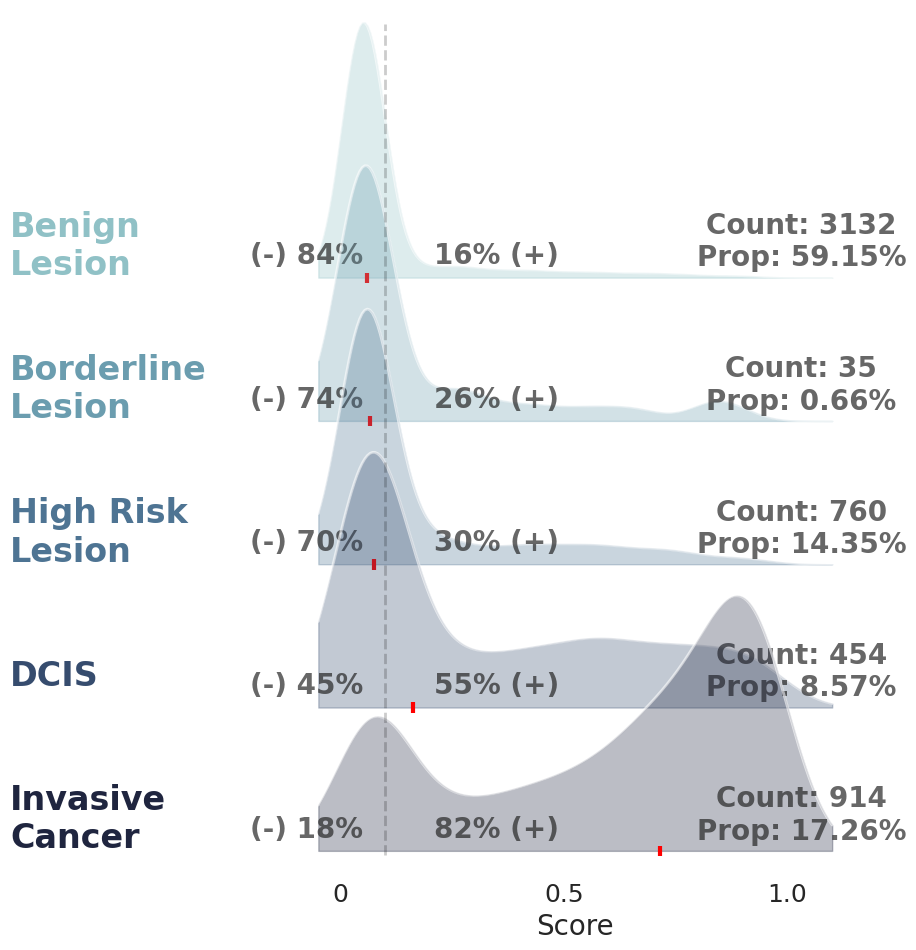

In [15]:
df = lunit_mag_exam_level_df.copy()

# config
linewidth_median = 3
color_median = "red"
ymin_adj_median = 0.02
ymax_adj_median = 0.02

# Set theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Replace the numeric values in 'exam_path_severity' with the corresponding labels
# df['exam_path_severity_map'] = df['exam_path_severity'].map(severity_labels)
df['exam_pathology'] = pd.Categorical(df['exam_pathology'], categories=['No\nPathology', 'Benign\nLesion', 'Borderline\nLesion', 'High Risk\nLesion', non_inv_cancer_n, 'Invasive\nCancer'], ordered=True)
df_temp = df[df.exam_pathology != "No\nPathology"].dropna(subset=["exam_pathology"])
df_temp['exam_pathology'] = df_temp['exam_pathology'].cat.remove_unused_categories()

# Initialize the FacetGrid object with a square aspect ratio and custom palette
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df_temp, row="exam_pathology", hue="exam_pathology", aspect=5.5, height=2, palette=pal)

# Draw the densities manually to normalize peak heights and apply correct colors
def plot_normalized_kde(data, color, **kwargs):
    ax = plt.gca()
    if len(data) == 0:
        return  # Skip if no data to plot
    
    # Calculate KDE using scipy
    scores = data["score"].values
    kde = gaussian_kde(scores, bw_method=0.25)
    x_vals = np.linspace(-0.05, 1.1, 200)
    y_vals = kde(x_vals)
    
    # Normalize the y-values
    y_vals_normalized = y_vals / np.max(y_vals)
    
    # Plot the normalized KDE with the correct color from the FacetGrid
    ax.plot(x_vals, y_vals_normalized, color='white', alpha=0.6, linewidth=2)  # White and translucent line
    ax.fill_between(x_vals, 0, y_vals_normalized, color=color, alpha=0.3)  # Use the correct color from the palette

# Apply normalized KDE function to the FacetGrid
g.map_dataframe(plot_normalized_kde)

# Add a single cutoff line across the entire figure
plt.axvline(x=0.1, linewidth=2, linestyle="--", color="black", clip_on=False, alpha=0.2, ymin=0.05,ymax=2.95)

# Add text annotation for the threshold line
# plt.gcf().text(0.675, 0.89, "Threshold (0.1)", ha='center', va='bottom', fontsize=24, color='gray')

# Add percentiles and labels to each distribution
def add_percentiles_and_info(data, **kwargs):
    ax = plt.gca()
    
    # Calculate the percentiles
    p25 = np.percentile(data['score'], 25)
    p50 = np.percentile(data['score'], 50)
    p75 = np.percentile(data['score'], 75)
    
    # Use a contrasting color (e.g., dark gray) for the percentile lines
    y_min, y_max = ax.get_ylim()
    y_min = 0
    ax.vlines(p50, y_min+ymin_adj_median, -(y_min + y_max*ymax_adj_median), color=color_median, linestyle='-', linewidth=linewidth_median)
    # ax.text(p50, -(y_min + y_max*0.07), "50%", ha='center', va='bottom', fontsize=10, color='black')
    
    # Calculate count and proportion
    total_count = len(data)
    proportion = total_count / len(df_temp)
    
    # Calculate data points above and below 0.1
    below_cutoff_count = len(data[data['score'] <= 0.1])
    below_cutoff_prop = below_cutoff_count / total_count if total_count > 0 else 0
    above_cutoff_count = len(data[data['score'] > 0.1])
    above_cutoff_prop = above_cutoff_count / total_count if total_count > 0 else 0
    
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_xticklabels([0, 0.5, 1.0], fontsize=18)
    
    # Annotate count and proportion above and below the cutoff
    ax.text(0.9, 0.19, f'Count: {total_count}\nProp: {proportion:.2%}', 
            ha='center', va='center', transform=ax.transAxes, fontsize=20, fontweight='bold', alpha=0.7)
    
    ax.text(-0.075, 0.14, f'(-) {below_cutoff_prop:.0%}', 
            ha='left', va='center', transform=ax.transAxes, fontsize=20, fontweight='bold', alpha=0.7)
    
    ax.text(0.25, 0.14, f'{above_cutoff_prop:.0%} (+)', 
            ha='left', va='center', transform=ax.transAxes, fontsize=20, fontweight='bold', alpha=0.7)

# Apply the function to the FacetGrid
g.map_dataframe(add_percentiles_and_info)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.5, 0.175, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=24)

g.map(label, "score")

g.set(xlabel="")
plt.xlabel("Score", fontsize=20)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show the final plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "outcomes_by_pathology.png", dpi=300, bbox_inches="tight")
plt.show()

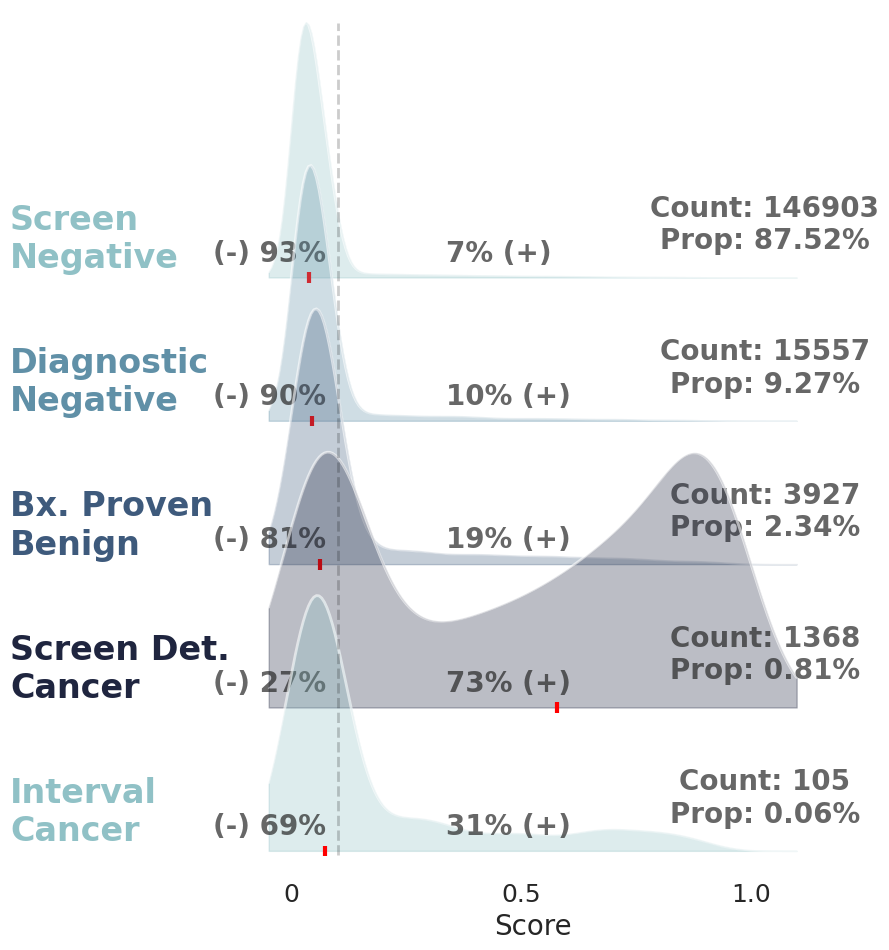

In [16]:
outcome_map = {'Screen Negative':'Screen\nNegative',
                'Diagnostic Negative':'Diagnostic\nNegative',
                scr_det_cancer : scr_det_cancer_n,
                bx_prov_benign : bx_prov_benign_n,
                'Interval Cancer':'Interval\nCancer'}

df['outcome_type'] = df['outcome_type'].map(outcome_map)

df['outcome_type'] = pd.Categorical(df['outcome_type'], categories=['Screen\nNegative', 'Diagnostic\nNegative', bx_prov_benign_n, scr_det_cancer_n,  'Interval\nCancer'], ordered=True)

# Set theme
df_temp = df.dropna(subset = "outcome_type")

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
g = sns.FacetGrid(df_temp, row="outcome_type", hue="outcome_type", aspect=5, height=2, palette=pal)

# Draw the densities manually to normalize peak heights and apply correct colors
def plot_normalized_kde(data, color, **kwargs):
    ax = plt.gca()
    if len(data) == 0:
        return  # Skip if no data to plot
    
    # Calculate KDE using scipy
    scores = data["score"].values
    kde = gaussian_kde(scores, bw_method=0.25)
    x_vals = np.linspace(-0.05, 1.1, 200)
    y_vals = kde(x_vals)
    
    # Normalize the y-values
    y_vals_normalized = y_vals / np.max(y_vals)
    
    # Plot the normalized KDE with the correct color from the FacetGrid
    ax.plot(x_vals, y_vals_normalized, color='white', alpha=0.6, linewidth=2)  # White and translucent line
    ax.fill_between(x_vals, 0, y_vals_normalized, color=color, alpha=0.3)  # Use the correct color from the palette

# Apply normalized KDE function to the FacetGrid
g.map_dataframe(plot_normalized_kde)    

# Add a single cutoff line across the entire figure
plt.axvline(x=0.1, linewidth=2, linestyle="--", color="black", clip_on=False, alpha=0.2, ymin=0.05,ymax=2.95)

# Add text annotation for the threshold line
# plt.gcf().text(0.6, 0.89, "Threshold (0.1)", ha='center', va='bottom', fontsize=24, color='gray')


# Add percentiles and labels to each distribution
def add_percentiles_and_info(data, **kwargs):
    ax = plt.gca()
    
    # Calculate the percentiles
    p25 = np.percentile(data['score'], 25)
    p50 = np.percentile(data['score'], 50)
    p75 = np.percentile(data['score'], 75)
    
    # Use a contrasting color (e.g., dark gray) for the percentile lines
    y_min, y_max = ax.get_ylim()
    y_min = 0
    # ax.vlines(p25, y_min, y_min + y_max*0.3, color='darkgray', linestyle='--', linewidth=1.5)
    ax.vlines(p50, y_min+ymin_adj_median, -(y_min + y_max*ymax_adj_median), color=color_median, linestyle='-', linewidth=linewidth_median)
    # ax.vlines(p75, y_min, y_min + y_max*0.3, color='darkgray', linestyle='--', linewidth=1.5)
    
    # Add text labels for the percentile lines
    # ax.text(p25, y_min + y_max*0.3, "25%", ha='center', va='bottom', fontsize=8, color='black')
    # ax.text(p50, -(y_min + y_max*0.07), "50%", ha='center', va='bottom', fontsize=8, color='black')
    # ax.text(p75, y_min + y_max*0.3, "75%", ha='center', va='bottom', fontsize=8, color='black')
    
#     ax.vlines(p25, y_min, y_min + y_max*0.02, color='darkgray', linestyle='--', linewidth=1.5)
    # ax.vlines(p50, y_min, y_min + y_max*0.02, color='darkgray', linestyle='-', linewidth=1)
#     ax.vlines(p75, y_min, y_min + y_max*0.02, color='darkgray', linestyle='--', linewidth=1.5)
    
#     # Add text labels for the percentile lines
#     ax.text(p25, y_min + y_max*0.02, "25%", ha='center', va='bottom', fontsize=8, color='black')
    # ax.text(p50, y_min + y_max*0.02, "50%", ha='center', va='bottom', fontsize=8, color='black')
#     ax.text(p75, y_min + y_max*0.02, "75%", ha='center', va='bottom', fontsize=8, color='black')    
    
    # Calculate count and proportion
    total_count = len(data)
    proportion = total_count / len(df_temp)
    
    # Calculate data points above and below 0.1
    below_cutoff_count = len(data[data['score'] <= 0.1])
    below_cutoff_prop = below_cutoff_count / total_count if total_count > 0 else 0
    above_cutoff_count = len(data[data['score'] > 0.1])
    above_cutoff_prop = above_cutoff_count / total_count if total_count > 0 else 0
    
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_xticklabels([0, 0.5, 1.0], fontsize=18)
    
    # Annotate count and proportion above and below the cutoff
    ax.text(0.9, 0.25, f'Count: {total_count}\nProp: {proportion:.2%}', 
            ha='center', va='center', transform=ax.transAxes, fontsize=20, fontweight="bold", alpha=0.7)
    
    ax.text(-0.05, 0.15, f'(-) {below_cutoff_prop:.0%}', 
            ha='left', va='center', transform=ax.transAxes, fontsize=20, fontweight="bold", alpha=0.7)
    
    ax.text(0.35, 0.15, f'{above_cutoff_prop:.0%} (+)', 
            ha='left', va='center', transform=ax.transAxes, fontsize=20, fontweight="bold", alpha=0.7)

# Apply the function to the FacetGrid
g.map_dataframe(add_percentiles_and_info)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.4, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=24)

g.map(label, "score")
g.set(xlabel="")
plt.xlabel("Score", fontsize=20)
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Show the final plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "outcome_characteristics_with_interval_cancer.png", dpi=300, bbox_inches="tight")
plt.show()

---

### 3. Pathology Subtypes

In [17]:
# Melt the dataframe to long format
lunit_mag_df_long = lunit_mag_df.melt(id_vars=['acc_anon','numfind','exam_pathology_numeric', 'score'], value_vars=["path"+str(i) for i in range(1,11)], 
                  var_name='path_column', value_name='pathology')

lunit_mag_df_long = lunit_mag_df_long.dropna(subset='exam_pathology_numeric')
lunit_mag_df_long = lunit_mag_df_long.dropna(subset='pathology')

# remove duplicates
lunit_mag_df_long['pathology_grouped'] = lunit_mag_df_long.groupby('acc_anon')['pathology'].transform(lambda x: ', '.join(x.unique()))
lunit_mag_df_long = lunit_mag_df_long.drop_duplicates(subset=['acc_anon','exam_pathology_numeric','pathology_grouped'])[['acc_anon','exam_pathology_numeric','score','pathology_grouped']]
lunit_mag_df_long['pathology_grouped'] = lunit_mag_df_long['pathology_grouped'].str.split(', ')  # Split the comma-separated values
lunit_mag_df_long = lunit_mag_df_long.explode('pathology_grouped').reset_index(drop=True)  # Explode the column to individual rows
lunit_mag_df_long = lunit_mag_df_long.rename(columns={'pathology_grouped':'pathology'})

# Map the severity dictionary to the pathologies (creates NaN if the pathology is not in the dict)
lunit_mag_df_long['path_severity_allowed'] = lunit_mag_df_long['pathology'].map(lambda x: key_order.get(x, []))

# Mapping similar pathologies
pathology_IDC_group_map = {"ID":"IDC",
                      "II":"IDC"}

pathology_ILC_group_map = {"IL":"ILC"}

pathology_IMC_group_map = {"I":"IMC"}

lunit_mag_df_long['pathology'] = lunit_mag_df_long['pathology'].replace(pathology_IDC_group_map)
lunit_mag_df_long['pathology'] = lunit_mag_df_long['pathology'].replace(pathology_ILC_group_map)
lunit_mag_df_long['pathology'] = lunit_mag_df_long['pathology'].replace(pathology_IMC_group_map)

# Filter top pathologies and order them
top_pathologies = ['IDC','TC','IPC','CC','MC','ILC','IMC']
lunit_mag_df_long_top_pth1 = lunit_mag_df_long[lunit_mag_df_long.pathology.isin(top_pathologies)]
pathology_labels['ILC'] = pathology_labels.pop('IL')

pathology_labels['IDC'] = 'Invasive Ductal Carcinoma'
pathology_labels['IMC'] = 'Invasive Mammary Carcinoma'
pathology_labels_n = {key: value.replace(' ', '\n') for key, value in pathology_labels.items()}

/tmp/ipykernel_2235176/4099979510.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_long_filtered['pathology'] = pd.Categorical(
/tmp/ipykernel_2235176/4099979510.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].count()
/tmp/ipykernel_2235176/4099979510.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

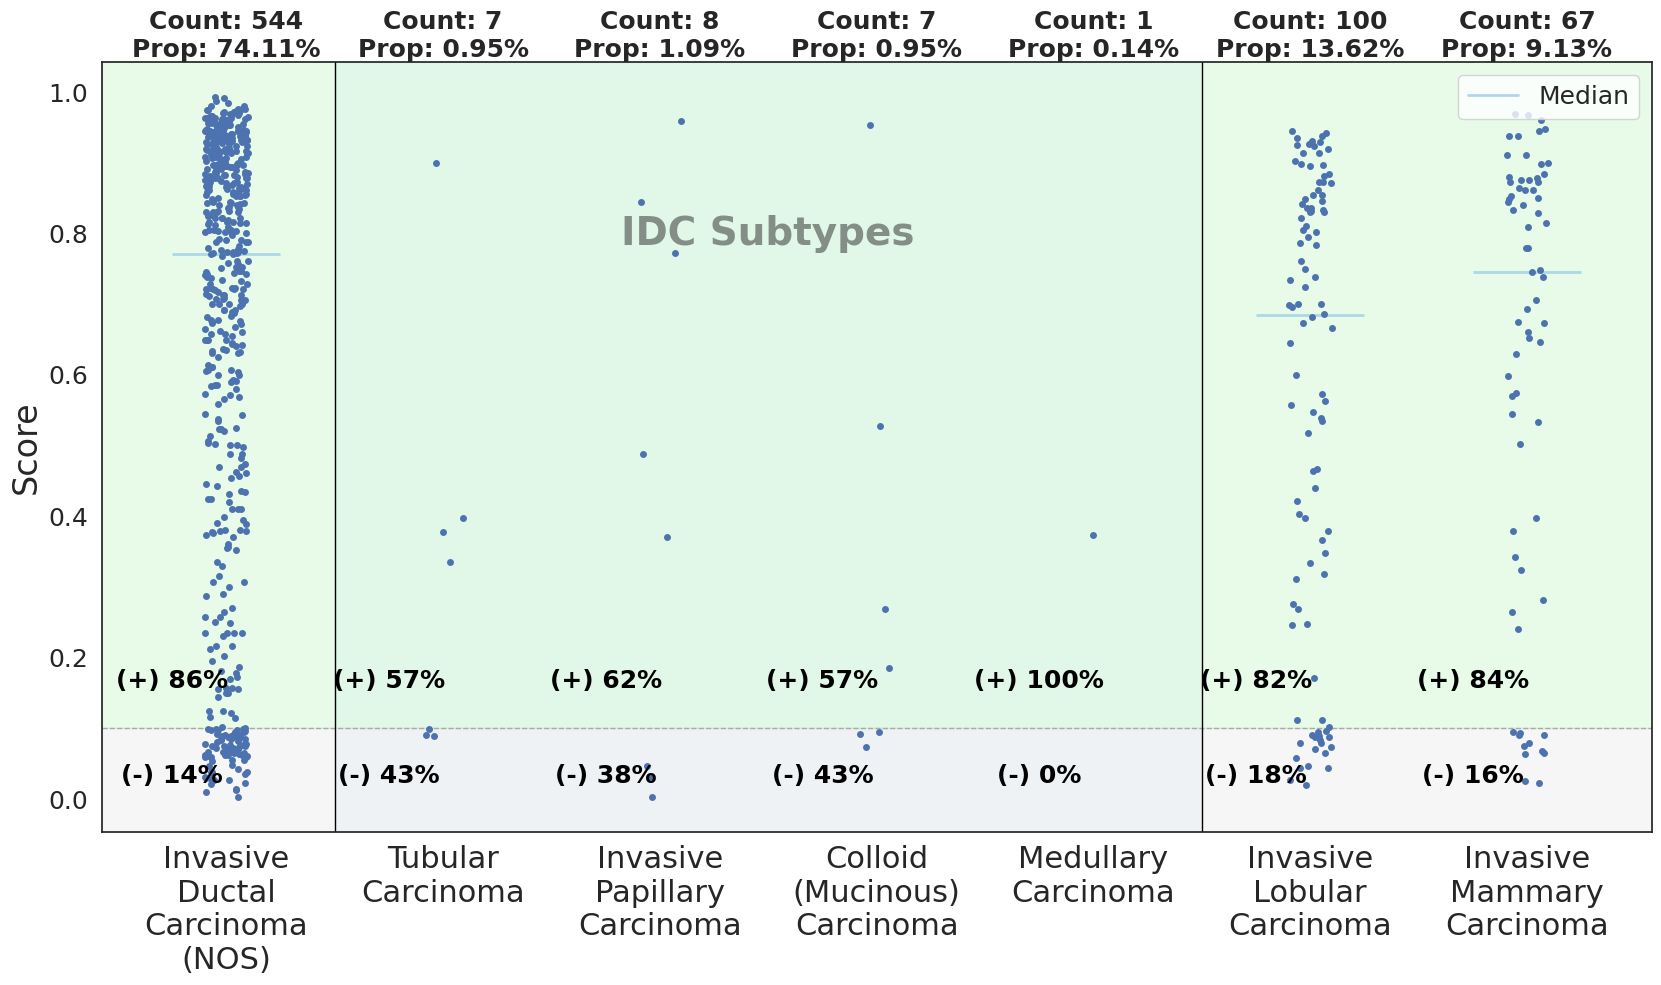

In [18]:
severity_value = 0

# Filter and process data
lunit_mag_df_long_filtered = lunit_mag_df_long[lunit_mag_df_long.apply(lambda row: row['exam_pathology_numeric'] in row['path_severity_allowed'], axis=1)]

# Ensure the pathology column is treated as a categorical column with the correct order
lunit_mag_df_long_filtered['pathology'] = pd.Categorical(
    lunit_mag_df_long_filtered['pathology'],
    categories=top_pathologies,
    ordered=True
)

# Calculate counts for each pathology
counts = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].count()
# Calculate proportions based on the total displayed data points
total_displayed_count = counts.sum()
proportions = counts / total_displayed_count

# Calculate counts and proportions based on cutoff (0.1)
below_cutoff_counts = lunit_mag_df_long_filtered[(lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)) & (lunit_mag_df_long_filtered['score'] <= cutoff)].groupby('pathology')['score'].count()
above_cutoff_counts = lunit_mag_df_long_filtered[(lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)) & (lunit_mag_df_long_filtered['score'] > cutoff)].groupby('pathology')['score'].count()

# Fill missing categories with 0 for consistency
below_cutoff_counts = below_cutoff_counts.reindex(top_pathologies, fill_value=0)
above_cutoff_counts = above_cutoff_counts.reindex(top_pathologies, fill_value=0)

# Create the plot
plt.figure(figsize=(20, 10))

# Calculate medians for each pathology
medians = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].median()

# Plot the strip plot
ax = sns.stripplot(x='pathology', y='score', data=lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)], jitter=True, dodge=True)

# Replace the pathology codes with (code) abbreviation
custom_labels = [f"{pathology_labels_n.get(code, code)}" for code in top_pathologies]
custom_labels[0] = custom_labels[0] + '\n(NOS)'

# Set the x-tick labels to match the correct number of categories and center them
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels, ha='center', fontsize=22)

plt.yticks(fontsize=18)

# Annotate counts and proportions above each category on the plot
for i, pathology in enumerate(top_pathologies):
    total_count = counts[pathology]
    total_prop = total_count / total_displayed_count  # Update to reflect only the displayed data
    
    below_count = below_cutoff_counts[pathology]
    above_count = above_cutoff_counts[pathology]
    
    below_prop = below_count / total_count if total_count > 0 else 0
    above_prop = above_count / total_count if total_count > 0 else 0
    
    # Annotate overall counts and proportions
    plt.text(i, 1.05, f'Count: {total_count}\nProp: {total_prop:.2%}', ha='center', fontsize=18, fontweight="semibold")
    
    # Annotate counts and proportions below and above the cutoff line
    plt.text(i - 0.25, cutoff - 0.05, f'(-) {below_prop:.0%}', 
             ha='center', va='top', fontsize=18, color='black', fontweight="semibold")
    plt.text(i - 0.25, cutoff + 0.05, f'(+) {above_prop:.0%}', 
             ha='center', va='bottom', fontsize=18, color='black', fontweight="semibold")
    
    # Draw median line if total_count > 20
    if total_count > 20:
        median_value = medians[pathology]
        # Add a horizontal line at the median value
        ax.hlines(y=median_value, xmin=i - 0.25, xmax=i + 0.25, color='lightblue', linestyle='-', linewidth=2)

# Add title
# plt.title('Invasive Cancers - Top Pathologies', pad=60)

# Add a horizontal dotted line at the cutoff value (0.1)
plt.axhline(y=cutoff, linestyle='--', color='darkgray', linewidth=1)

# Shade the area below and above the cutoff line
plt.axhspan(-0.1, cutoff, color='lightgray', alpha=0.2)  # Below 0.1
plt.axhspan(cutoff, 1.1, color='lightgreen', alpha=0.2)  # Above 0.1

# Add vertical lines to separate major types and subtypes
plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1)  # After IDC
plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)  # Before ILC

# Background shading for IDC subtypes
plt.axvspan(0.5, 4.5, color='lightblue', alpha=0.1)  # IDC subtypes

# Add a label "IDC Subtypes" above the x-axis
plt.text(2.5, 0.8, "IDC Subtypes", fontsize=28, fontweight='bold', ha='center', va='center', alpha=0.5)

# Create a legend for the median line
median_legend = mlines.Line2D([], [], color='lightblue', linestyle='-', linewidth=2, label='Median')
plt.legend(handles=[median_legend], loc='upper right', fontsize=18, facecolor='white')

plt.xlabel("")
plt.ylabel("Score", fontsize=24)

# Show plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "invasive_cancer_pathology_outcomes.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_2235176/2301729024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_long_filtered['pathology'] = pd.Categorical(
/tmp/ipykernel_2235176/2301729024.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].count()
/tmp/ipykernel_2235176/2301729024.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curren

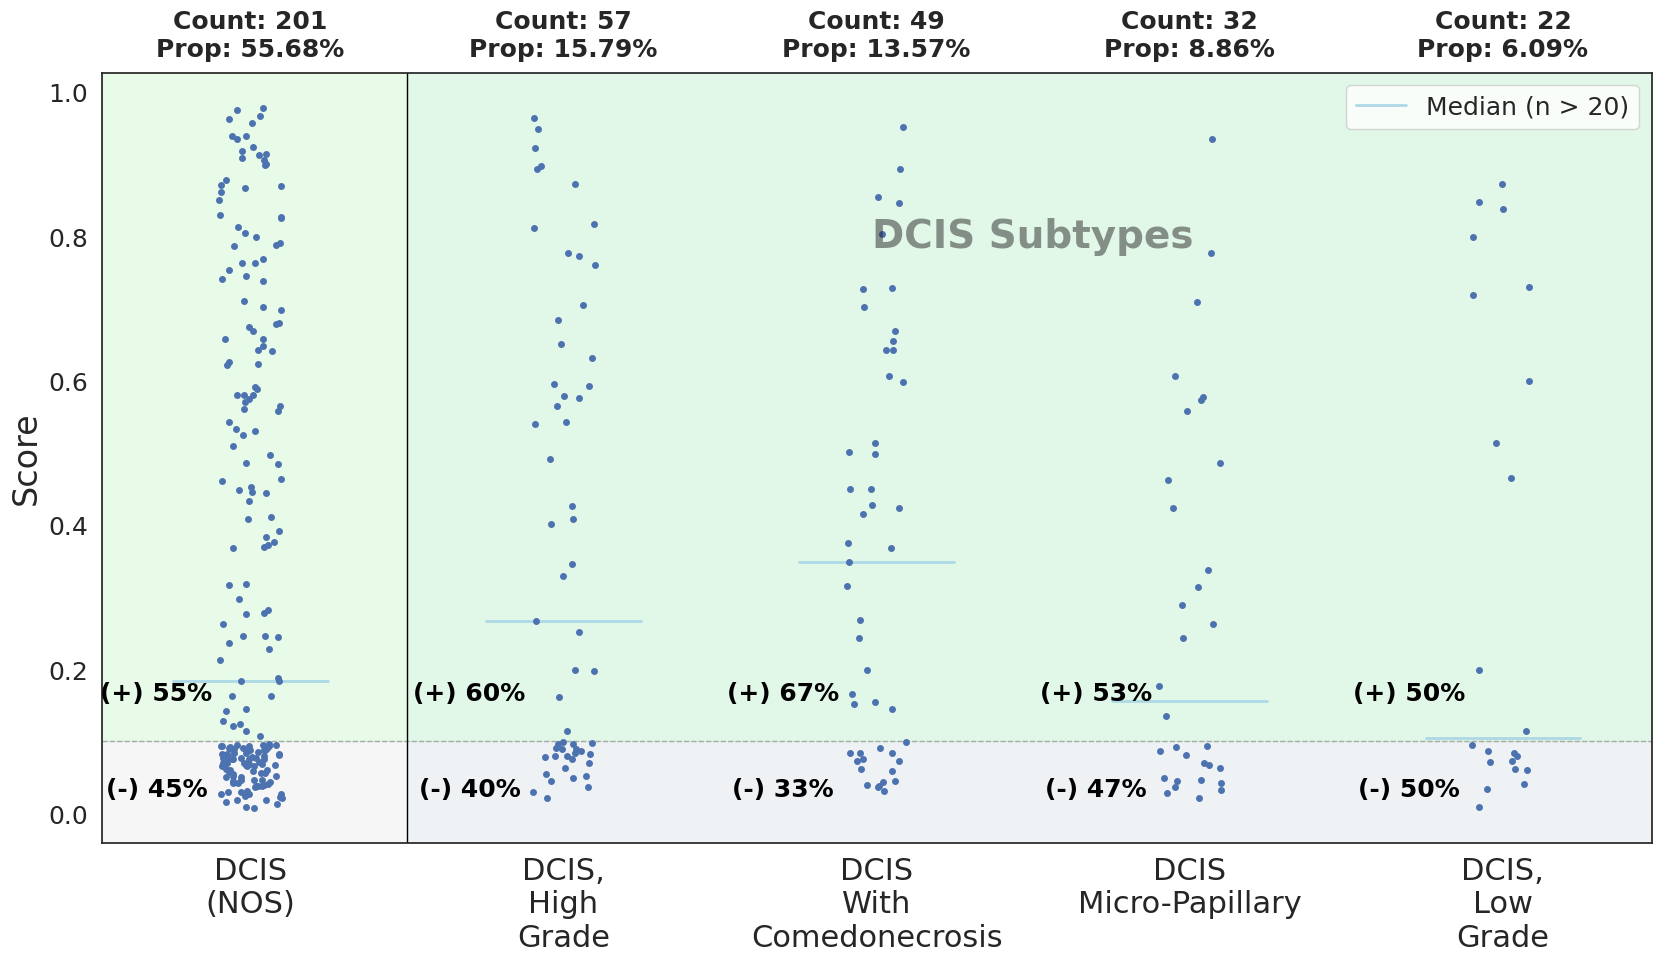

In [19]:
severity_value = 1

# Filter and process data
lunit_mag_df_long_filtered = lunit_mag_df_long[lunit_mag_df_long.apply(lambda row: row['exam_pathology_numeric'] in row['path_severity_allowed'], axis=1)]

# Filter the top pathologies for the specific severity
top_pathologies = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['exam_pathology_numeric'] == severity_value]['pathology'].value_counts().index[:20]

top_pathologies = [p for p in top_pathologies if p != 'PC'][:20]

# Ensure the pathology column is treated as a categorical column with the correct order
lunit_mag_df_long_filtered['pathology'] = pd.Categorical(
    lunit_mag_df_long_filtered['pathology'],
    categories=top_pathologies,
    ordered=True
)

# Calculate counts for each pathology
counts = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].count()
# Calculate proportions based on the total displayed data points
total_displayed_count = counts.sum()
proportions = counts / total_displayed_count

# Calculate counts and proportions based on cutoff (0.1)
below_cutoff_counts = lunit_mag_df_long_filtered[(lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)) & (lunit_mag_df_long_filtered['score'] <= cutoff)].groupby('pathology')['score'].count()
above_cutoff_counts = lunit_mag_df_long_filtered[(lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)) & (lunit_mag_df_long_filtered['score'] > cutoff)].groupby('pathology')['score'].count()

# Fill missing categories with 0 for consistency
below_cutoff_counts = below_cutoff_counts.reindex(top_pathologies, fill_value=0)
above_cutoff_counts = above_cutoff_counts.reindex(top_pathologies, fill_value=0)

# Create the plot
plt.figure(figsize=(20, 10))

# Calculate medians for each pathology
medians = lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)].groupby('pathology')['score'].median()

# Plot the strip plot
ax = sns.stripplot(x='pathology', y='score', data=lunit_mag_df_long_filtered[lunit_mag_df_long_filtered['pathology'].isin(top_pathologies)], jitter=True, dodge=True)

# Replace the pathology codes with (code) abbreviation
custom_labels = [f"{pathology_labels_n.get(code, code)}" for code in top_pathologies]
custom_labels = [term.replace('Dcis', 'DCIS') for term in custom_labels]
custom_labels[0] = custom_labels[0] + '\n(NOS)'

# Set the x-tick labels to match the correct number of categories
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels, ha='center', fontsize=22)

plt.yticks(fontsize=18)
# Annotate counts and proportions above each category on the plot
for i, pathology in enumerate(top_pathologies):
    total_count = counts[pathology]
    total_prop = total_count / total_displayed_count  # Update to reflect only the displayed data
    
    below_count = below_cutoff_counts[pathology]
    above_count = above_cutoff_counts[pathology]
    
    below_prop = below_count / total_count if total_count > 0 else 0
    above_prop = above_count / total_count if total_count > 0 else 0
    
    # Annotate overall counts and proportions
    plt.text(i, 1.05, f'Count: {total_count}\nProp: {total_prop:.2%}', ha='center', fontsize=18, fontweight="semibold")
    
    # Annotate counts and proportions below and above the cutoff line
    plt.text(i - 0.3, cutoff - 0.05, f'(-) {below_prop:.0%}', 
             ha='center', va='top', fontsize=18, color='black', fontweight="semibold")
    plt.text(i - 0.3, cutoff + 0.05, f'(+) {above_prop:.0%}', 
             ha='center', va='bottom', fontsize=18, color='black', fontweight="semibold")
    
    # Draw median line if total_count > 20
    if total_count > 20:
        median_value = medians[pathology]
        # Add a horizontal line at the median value
        ax.hlines(y=median_value, xmin=i - 0.25, xmax=i + 0.25, color='lightblue', linestyle='-', linewidth=2)

# Shade the area below and above the cutoff line
plt.axhspan(-0.1, cutoff, color='lightgray', alpha=0.2)  # Below 0.1
plt.axhspan(cutoff, 1.1, color='lightgreen', alpha=0.2)  # Above 0.1

# Add title
# plt.title('Non-Invasive Cancers - Top Pathologies', pad=60)  # Add padding to title

# Add a horizontal dotted line at the cutoff value (0.1)
plt.axhline(y=cutoff, linestyle='--', color='darkgray', linewidth=1)

# Add vertical lines to separate major types and subtypes
plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1)  # After IDC
# plt.axvline(x=4.5, color='black', linestyle='-', linewidth=1)  # Before ILC

# Background shading for IDC subtypes
plt.axvspan(0.5, 4.5, color='lightblue', alpha=0.1)  # IDC subtypes

# Add a label "IDC Subtypes" above the x-axis
plt.text(2.5, 0.8, "DCIS Subtypes", fontsize=28, fontweight='bold', ha='center', va='center', alpha=0.5)


# Create a legend for the median line
median_legend = mlines.Line2D([], [], color='lightblue', linestyle='-', linewidth=2, label='Median (n > 20)')
plt.legend(handles=[median_legend], loc='upper right', fontsize=18, facecolor='white')

plt.xlabel("")
plt.ylabel("Score", fontsize=24)

# Show plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "noninvasive_cancer_pathology_outcomes.png", dpi=300, bbox_inches="tight")
plt.show()

---

### 4. BIRADS Descriptor Outcomes

#### 4.1 Mass Shape

In [20]:
# convert massshape acronyms to their abbreviations
lunit_mag_df_AB_dedup['massshape'] = lunit_mag_df_AB_dedup['massshape'].astype(str).apply(lambda x: massshape_mapping.get(x, x) + f' ({x})' if '(' not in x else x)

/tmp/ipykernel_2235176/1785909232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['massshape'] = lunit_mag_df_AB_dedup['massshape'].astype(str).apply(lambda x: massshape_mapping.get(x, x) + f' ({x})' if '(' not in x else x)


/tmp/ipykernel_2235176/1266242701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
/tmp/ipykernel_2235176/1266242701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
/tmp/ipykernel_2235176/1266242701.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

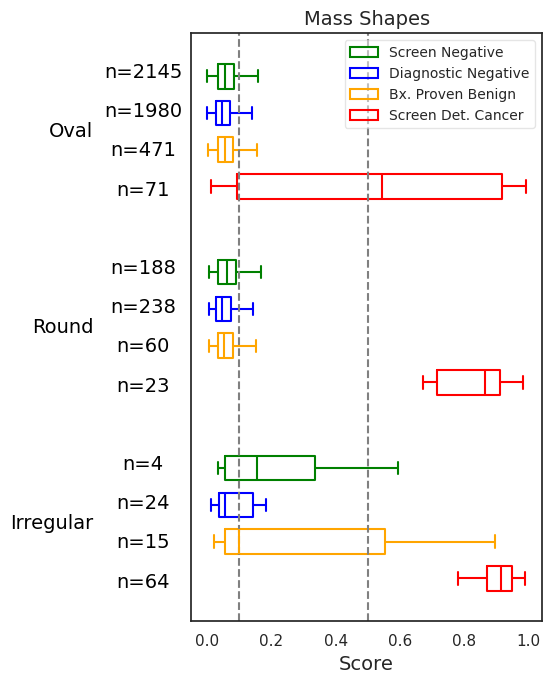

In [21]:
find_type = 'massshape'
desired_order = ['Oval (O)', 'Round (R)','Irregular (X)']  # Define the desired order
lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
lunit_mag_df_subset = lunit_mag_df_AB_dedup.copy()
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[lunit_mag_df_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_subset = lunit_mag_df_subset[(lunit_mag_df_subset.massshape.isin(desired_order)) & (lunit_mag_df_subset.mass == 1)]  # Remove Generic
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_subset[find_type] = pd.Categorical(
    lunit_mag_df_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 7))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)


# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.15,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='center',
        va='center',
        fontsize=14,
        color='black'
    )
    
# Customize the plot
ax.set_title('Mass Shapes', fontsize=14, loc="center")
ax.set_xlabel('Score', fontsize=14)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=14)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.28  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=14,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=12,
          facecolor='white', prop={'size':10},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "mass_shapes_by_outcome_characteristics_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### 4.2 Asymmetry

In [22]:
# set specific fontsize
as_fontsize=12

/tmp/ipykernel_2235176/4273293295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
/tmp/ipykernel_2235176/4273293295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
/tmp/ipykernel_2235176/4273293295.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a fut

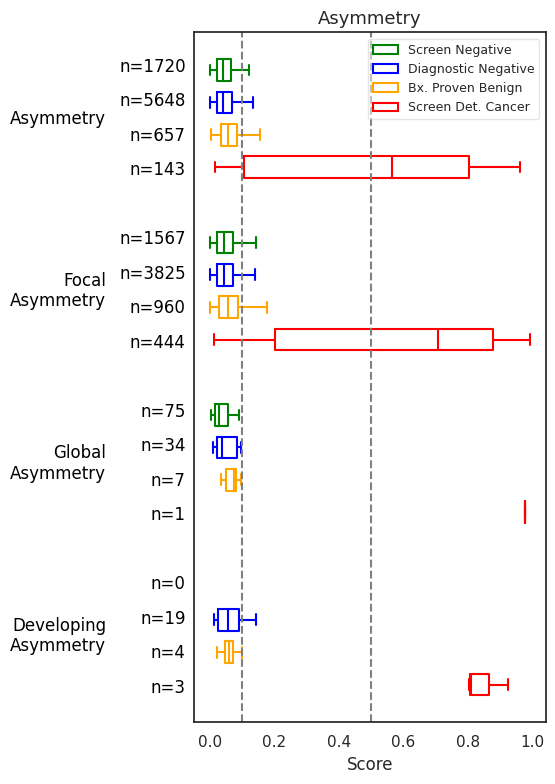

In [23]:
find_type = 'massshape'
desired_order = ['Asymmetry (S)','Focal asymmetry (F)','Global asymmetry (B)', 'Developing asymmetry (V)']  # Define the desired order
lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
lunit_mag_df_subset = lunit_mag_df_AB_dedup.copy()
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[lunit_mag_df_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_subset = lunit_mag_df_subset[(lunit_mag_df_subset.massshape.isin(desired_order)) & (lunit_mag_df_subset.asymmetry == 1)]  # Remove Generic
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_subset[find_type] = pd.Categorical(
    lunit_mag_df_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.025,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='right',
        va='center',
        fontsize=as_fontsize,
        color='black'
    )
    
# Customize the plot
ax.set_title('Asymmetry', fontsize=as_fontsize+1, loc="center")
ax.set_xlabel('Score', fontsize=as_fontsize)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.25  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=as_fontsize,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=12,
          facecolor='white', prop={'size':9},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "asymmetry_by_outcome_characteristics_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### 4.3 Architectural Distortion

/tmp/ipykernel_2235176/1000122001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
/tmp/ipykernel_2235176/1000122001.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
/tmp/ipykernel_2235176/1000122001.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a fut

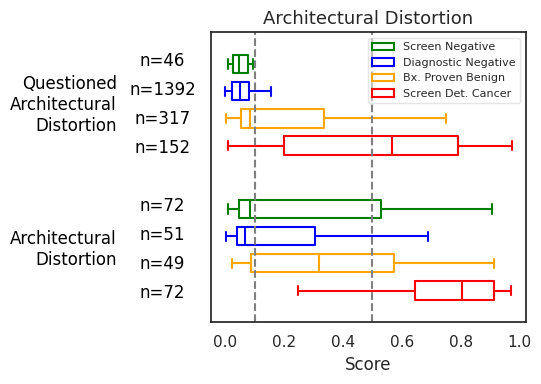

In [24]:
ad_fontsize=12

find_type = 'massshape'
desired_order = ['Questioned architectural distortion (Q)', 'Architectural distortion (A)']  # Define the desired order
lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
lunit_mag_df_subset = lunit_mag_df_AB_dedup.copy()
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[lunit_mag_df_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_subset = lunit_mag_df_subset[(lunit_mag_df_subset.massshape.isin(desired_order))  & (lunit_mag_df_subset.arch_distortion == 1)]  # Remove Generic
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_subset[find_type] = pd.Categorical(
    lunit_mag_df_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.165,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='center',
        va='center',
        fontsize=ad_fontsize,
        color='black'
    )
    
# Customize the plot
ax.set_title('Architectural Distortion', fontsize=ad_fontsize+1, loc="center")
ax.set_xlabel('Score', fontsize=ad_fontsize)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.3  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=ad_fontsize,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=ad_fontsize,
          facecolor='white', prop={'size':8},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "arch_distortion_by_outcome_characteristics_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### 4.4 Mass Margins

In [25]:
# convert massmargin acronyms to their abbreviations
lunit_mag_df_AB_dedup['massmargin'] = lunit_mag_df_AB_dedup['massmargin'].astype(str).apply(lambda x: massmargin_map.get(x, x) + f' ({x})' if '(' not in x else x)

/tmp/ipykernel_2235176/3445788348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['massmargin'] = lunit_mag_df_AB_dedup['massmargin'].astype(str).apply(lambda x: massmargin_map.get(x, x) + f' ({x})' if '(' not in x else x)


In [26]:
mm_fontsize = 15

/tmp/ipykernel_2235176/1607333244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
/tmp/ipykernel_2235176/1607333244.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
/tmp/ipykernel_2235176/1607333244.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

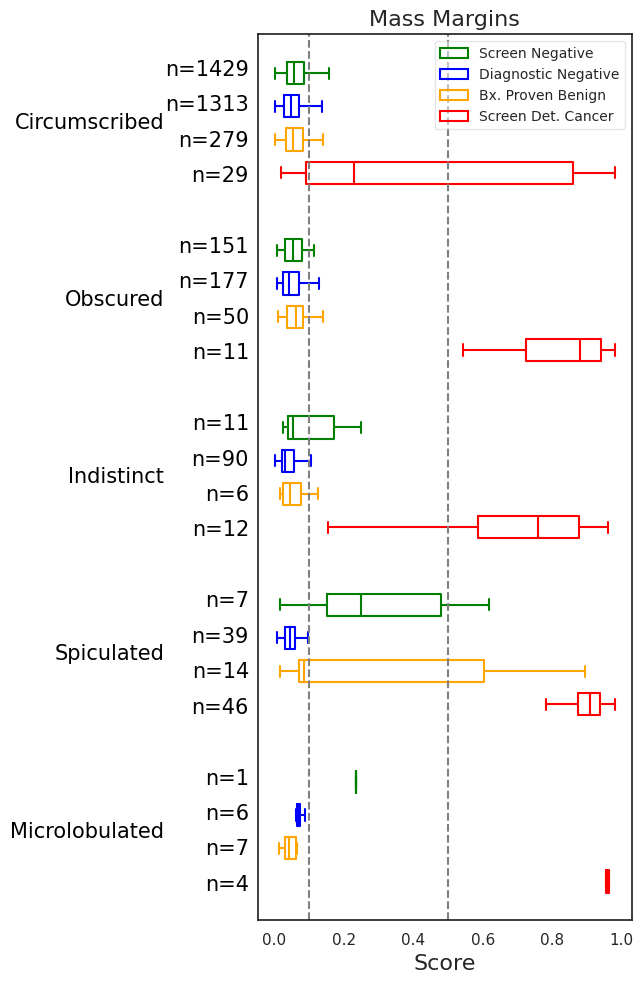

In [27]:
find_type = 'massmargin'
desired_order = ['Circumscribed (D)','Obscured (U)', 'Indistinct (I)', 'Spiculated (S)', 'Microlobulated (M)']  # Define the desired order
lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
lunit_mag_df_subset = lunit_mag_df_AB_dedup.copy()
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[lunit_mag_df_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_subset = lunit_mag_df_subset[(lunit_mag_df_subset[find_type].isin(desired_order)) & ((lunit_mag_df_subset.mass == 1) | lunit_mag_df_subset.asymmetry == 1)]  # Remove Generic
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_subset[find_type] = pd.Categorical(
    lunit_mag_df_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(7, 10))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.025,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='right',
        va='center',
        fontsize=mm_fontsize,
        color='black'
    )
    
# Customize the plot
ax.set_title('Mass Margins', fontsize=mm_fontsize+1, loc="center")
ax.set_xlabel('Score', fontsize=mm_fontsize+1)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.25  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=mm_fontsize,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=14,
          facecolor='white', prop={'size':10},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "mass_margins_by_outcome_characteristics_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### 4.5 Calcification Findings

In [28]:
# filter dataframe
lunit_mag_df_AB_dedup_temp = lunit_mag_df_AB_dedup[['empi_anon','acc_anon','outcome_type','calcfind','score']].copy()

# code mappings and filter
lunit_mag_df_AB_dedup_temp.calcfind = lunit_mag_df_AB_dedup_temp.calcfind.replace({'A,P':'A', 'A,M':'A'})
lunit_mag_df_AB_dedup_temp = lunit_mag_df_AB_dedup_temp[lunit_mag_df_AB_dedup_temp.calcfind.isin(['A', 'P', 'H', 'Q', 'D', 'M', 'R', 'C', 'O', 'S', 'K', 'V','J', 'L','I', 'E'])]

# Dictionary for value replacement
replacement_dict = {'Q': ['Q', 'C'], 'I':['I','K'], 'S':['S','O']}

# Function to apply replacement based on dictionary
def replace_values(value):
    for key, vals in replacement_dict.items():
        if value in vals:
            return key
    return value


lunit_mag_df_AB_dedup_temp['calcfind'] = lunit_mag_df_AB_dedup_temp['calcfind'].str.split(',')
lunit_mag_df_AB_dedup_temp = lunit_mag_df_AB_dedup_temp.explode('calcfind')

lunit_mag_df_AB_dedup_temp['calcfind'] = lunit_mag_df_AB_dedup_temp['calcfind'].apply(replace_values)

In [29]:
# convert calcfind acronyms to their abbreviations
lunit_mag_df_AB_dedup_temp['calcfind'] = lunit_mag_df_AB_dedup_temp['calcfind'].astype(str).apply(lambda x: calfind_labels.get(x, x) + f' ({x})' if '(' not in x else x)

# split codes to categories
typically_benign_categories = ['Skin (S)','Vascular (V)','Coarse (Q)','Large Rodlike (L)', 'Round (R)', 'Rim (E)', 'Dystrophic (D)', 'Milk of calcium (M)']
suspicious_morphology_categories = ['Fine pleomorph (I)', 'Coarse hetero (H)', 'Amorphous (A)']
all_categories = typically_benign_categories + suspicious_morphology_categories

# convert to categorical type
lunit_mag_df_AB_dedup_temp['calcfind'] = pd.Categorical(lunit_mag_df_AB_dedup_temp['calcfind'], categories=all_categories, ordered=True)
lunit_mag_df_AB_dedup_temp = lunit_mag_df_AB_dedup_temp.reset_index(drop=True)

- Typically Benign Categories

/tmp/ipykernel_2235176/2653165943.py:28: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].replace(dict(zip(desired_order, processed_order)))
/tmp/ipykernel_2235176/2653165943.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = lunit_mag_df_temp_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')


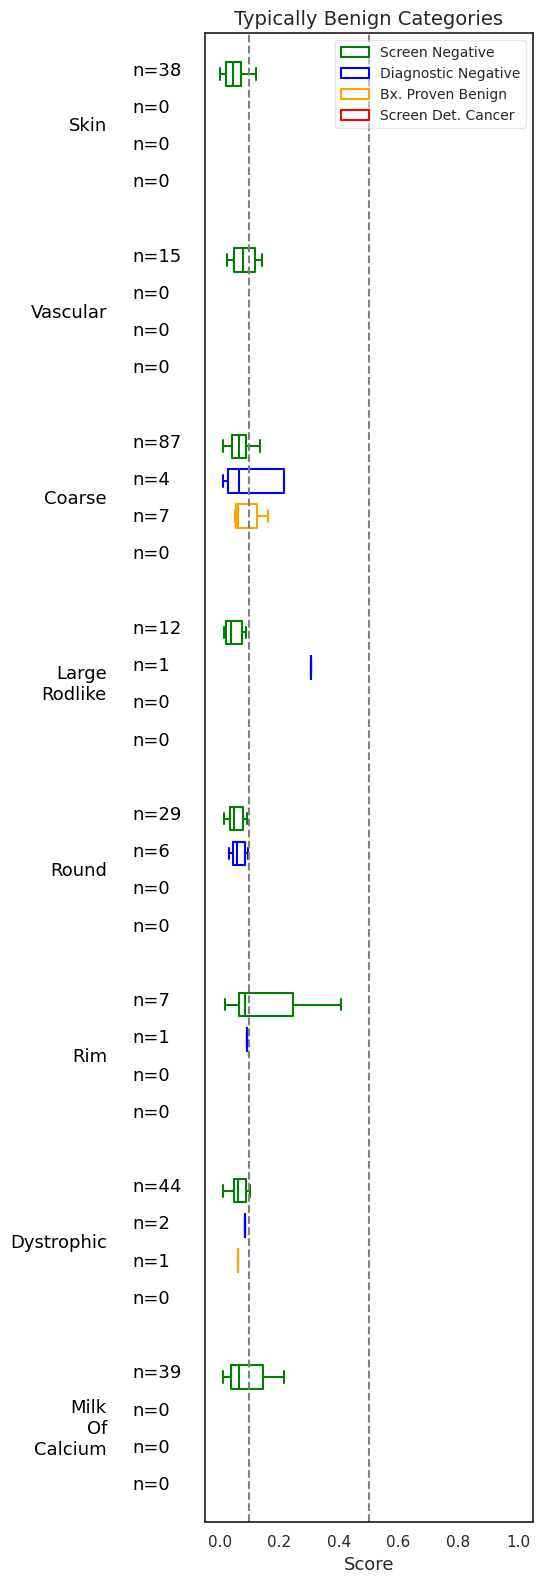

In [30]:
mm_fontsize = 13
typically_benign_count = 8
suspicious_morphology_count = 3

find_type = 'calcfind'
desired_order = typically_benign_categories  # Define the desired order
lunit_mag_df_AB_dedup_temp['outcome_type'] = lunit_mag_df_AB_dedup_temp['outcome_type'].astype('category')
lunit_mag_df_AB_dedup_temp[find_type] = lunit_mag_df_AB_dedup_temp[find_type].astype('category')
lunit_mag_df_temp_subset = lunit_mag_df_AB_dedup_temp.copy()
lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[lunit_mag_df_temp_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_temp_subset = lunit_mag_df_temp_subset[lunit_mag_df_temp_subset[find_type].isin(desired_order)]  # Remove Generic
lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_temp_subset[find_type] = pd.Categorical(
    lunit_mag_df_temp_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_temp_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 16))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_temp_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_temp_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup_temp['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.275,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='left',
        va='center',
        fontsize=mm_fontsize,
        color='black'
    )
    
# Customize the plot
ax.set_title('Typically Benign Categories', fontsize=14, loc="center")
ax.set_xlabel('Score', fontsize=mm_fontsize)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.3  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=mm_fontsize,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold
ax.axvline(x=1, linestyle='', color='gray')

ypos=0
# Add shaded backgrounds and annotations
# ax.axhspan(ymin=7.5 , ymax=12, color='lightcoral', alpha=0.2)
# ax.axhspan(ymin=-1, ymax=7.5, color='lightblue', alpha=0.2)

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=14,
          facecolor='white', prop={'size':10},
          framealpha=0.5)
plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "calc_findings_by_outcome_characteristics_typically_benign_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

- Suspicious Morphology Categories

/tmp/ipykernel_2235176/931301779.py:28: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].replace(dict(zip(desired_order, processed_order)))
/tmp/ipykernel_2235176/931301779.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sizes = lunit_mag_df_temp_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')


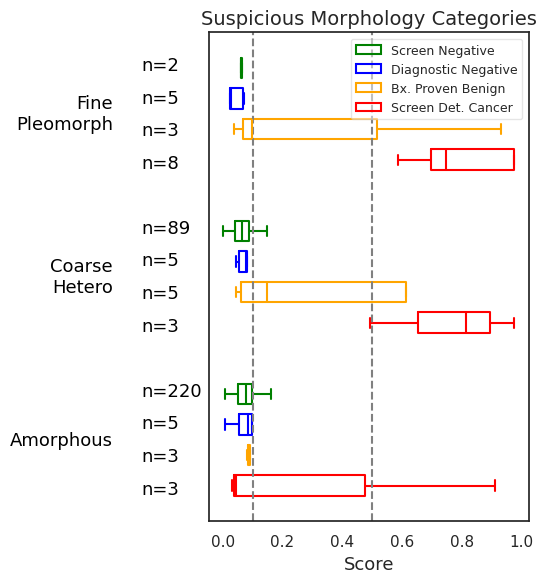

In [31]:
mm_fontsize = 13
typically_benign_count = 8
suspicious_morphology_count = 3

find_type = 'calcfind'
desired_order = suspicious_morphology_categories  # Define the desired order
lunit_mag_df_AB_dedup_temp['outcome_type'] = lunit_mag_df_AB_dedup_temp['outcome_type'].astype('category')
lunit_mag_df_AB_dedup_temp[find_type] = lunit_mag_df_AB_dedup_temp[find_type].astype('category')
lunit_mag_df_temp_subset = lunit_mag_df_AB_dedup_temp.copy()
lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[lunit_mag_df_temp_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_temp_subset = lunit_mag_df_temp_subset[lunit_mag_df_temp_subset[find_type].isin(desired_order)]  # Remove Generic
lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].str[:-4].astype('category')  # Ensure it's a category

desired_order = [cat[:-4] for cat in desired_order]

lunit_mag_df_temp_subset[find_type] = pd.Categorical(
    lunit_mag_df_temp_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace(' ', '\n') for word in desired_order
]

lunit_mag_df_temp_subset[find_type] = lunit_mag_df_temp_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_temp_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_temp_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_temp_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup_temp['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.225,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='left',
        va='center',
        fontsize=mm_fontsize,
        color='black'
    )
    
# Customize the plot
ax.set_title('Suspicious Morphology Categories', fontsize=14, loc="center")
ax.set_xlabel('Score', fontsize=mm_fontsize)
# Adjust y-axis label
ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.3  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=mm_fontsize,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

ypos=0
# Add shaded backgrounds and annotations
# ax.axhspan(ymin=7.5 , ymax=12, color='lightcoral', alpha=0.2)
# ax.axhspan(ymin=-1, ymax=7.5, color='lightblue', alpha=0.2)

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=14,
          facecolor='white', prop={'size':9},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "calc_findings_by_outcome_characteristics_suspicious_morphology_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

#### 4.6 Calcification Distribution

In [32]:
# convert calc distribution acronyms to their abbreviations
lunit_mag_df_AB_dedup['calcdistri'] = lunit_mag_df_AB_dedup['calcdistri'].astype(str).apply(lambda x: calcdistri_mapping.get(x, x) + f' ({x})' if '(' not in x else x)
# replacements based on ACR BIRADS manual for consistency
lunit_mag_df_AB_dedup['calcdistri'] = lunit_mag_df_AB_dedup['calcdistri'].replace({'Clustered (C)':'Grouped (G)'})

/tmp/ipykernel_2235176/3725505946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['calcdistri'] = lunit_mag_df_AB_dedup['calcdistri'].astype(str).apply(lambda x: calcdistri_mapping.get(x, x) + f' ({x})' if '(' not in x else x)
/tmp/ipykernel_2235176/3725505946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['calcdistri'] = lunit_mag_df_AB_dedup['calcdistri'].replace({'Clustered (C)':'Grouped (G)'})


/tmp/ipykernel_2235176/1653427847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
/tmp/ipykernel_2235176/1653427847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
/tmp/ipykernel_2235176/1653427847.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a fut

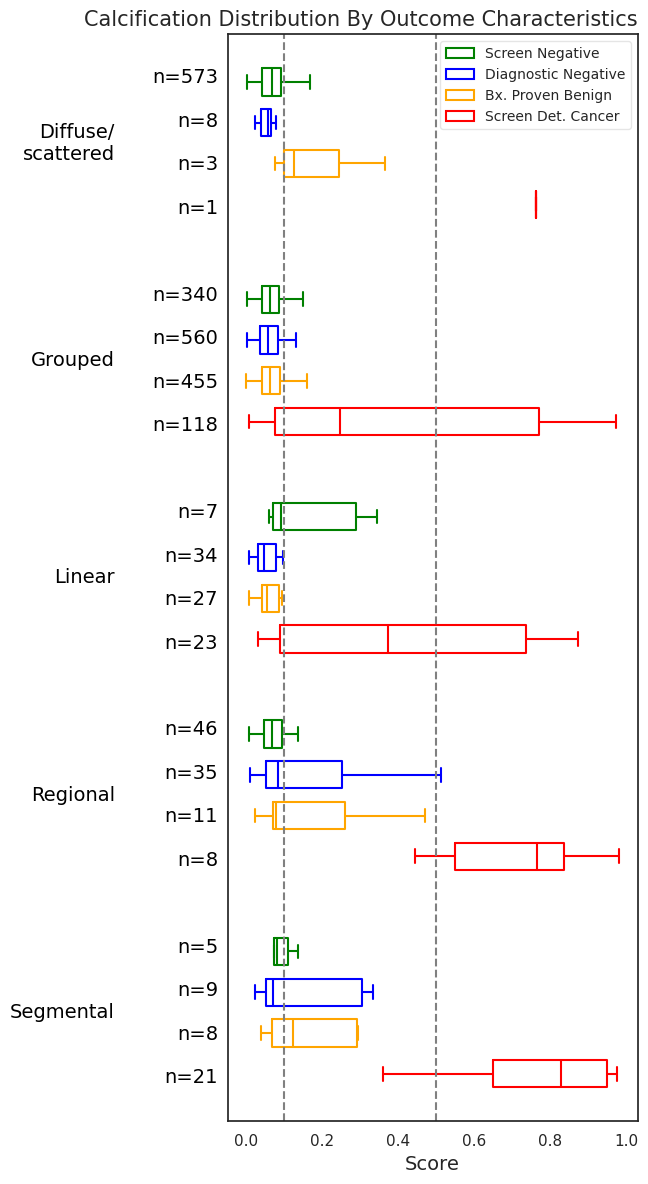

In [33]:
find_type = 'calcdistri'
desired_order = ['Diffuse/scattered (D)','Grouped (G)', 'Linear (L)', 'Regional (R)', 'Segmental (S)']  # Define the desired order
lunit_mag_df_AB_dedup['outcome_type'] = lunit_mag_df_AB_dedup['outcome_type'].astype('category')
lunit_mag_df_AB_dedup[find_type] = lunit_mag_df_AB_dedup[find_type].astype('category')
lunit_mag_df_subset = lunit_mag_df_AB_dedup.copy()
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[lunit_mag_df_subset[find_type] != 'nan (nan)'][find_type].cat.remove_unused_categories()

lunit_mag_df_subset = lunit_mag_df_subset[lunit_mag_df_subset[find_type].isin(desired_order)]  # Remove Generic
lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].str[:-4].astype('category')  # Ensure it's a category
desired_order = [cat[:-4] for cat in desired_order]


lunit_mag_df_subset[find_type] = pd.Categorical(
    lunit_mag_df_subset[find_type],
    categories=desired_order,
    ordered=True
)

# Process the list
processed_order = [
    ' '.join(w.capitalize() for w in word.split('(')[0].strip().split()).replace('/', '/\n') for word in desired_order
]

lunit_mag_df_subset[find_type] = lunit_mag_df_subset[find_type].replace(dict(zip(desired_order, processed_order)))

# Compute sample sizes
sample_sizes = lunit_mag_df_subset.groupby([find_type, 'outcome_type']).size().reset_index(name='n')

# Define properties for mean point
meanprops = {
    "markerfacecolor": "black",  # Change mean point color to black
    "markeredgecolor": "black",  # Add a black border to the mean point
    "markersize": 4,  # Adjust the size of the mean point
}

# Create the plot
fig, ax = plt.subplots(figsize=(7, 12))

# Draw the boxplot
sns.boxplot(
    data=lunit_mag_df_subset,
    x='score',
    y=find_type,
    hue='outcome_type',
    palette=category_colors_map,
    dodge=True,
    # showmeans=True,
    # meanprops=meanprops,
    width=0.75,
    ax=ax,
    showfliers=False,  # Optional: Hide outliers
    gap=.33,
    fill=False,
)

# Annotate sample sizes
for _, row in sample_sizes.iterrows():
    massshape = row[find_type]
    outcome_type = row['outcome_type']
    count = row['n']

    # Find the corresponding y position
    y_position = list(lunit_mag_df_subset[find_type].cat.categories).index(massshape)
    hue_offset = list(lunit_mag_df_AB_dedup['outcome_type'].cat.categories).index(outcome_type) * 0.2  # Adjust hue offset dynamically

    # Annotate
    ax.text(
        x=ax.get_xlim()[0] - 0.025,  # Adjust x-position for better placement
        y=y_position + hue_offset - 0.3,
        s=f'n={count}',
        ha='right',
        va='center',
        fontsize=14,
        color='black'
    )
    
# Customize the plot
ax.set_title('Calcification Distribution By Outcome Characteristics', fontsize=15, loc="right")
ax.set_xlabel('Score', fontsize=14)
# Adjust y-axis label
# ax.set_ylabel('Mass Shape', labelpad=40)  # Move y-axis label to the left

# Customize y-axis tick labels and position
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
y_tick_positions = ax.get_yticks()  # Get current y positions
custom_x = -0.275  # Adjust this value to shift labels to the left

# Manually position labels
for label, y_pos in zip(y_tick_labels, y_tick_positions):
    ax.text(
        custom_x, y_pos, label,  # Custom x position and y position
        ha='right',  # Align to the right
        va='center',  # Vertically centered
        transform=ax.get_yaxis_transform(),  # Relative to y-axis
        fontsize=14,
        color='black'
    )

# Hide default y-tick labels
ax.set_yticks([])
ax.set_ylabel('')  # Optional: Remove default y-label

ax.axvline(x=0.5, linestyle='--', color='gray')  # Optional threshold
ax.axvline(x=0.1, linestyle='--', color='gray')  # Optional low threshold

# Add legend
ax.legend(title=None, loc='upper right',
          fontsize=14,
          facecolor='white', prop={'size':10},
          framealpha=0.5)

plt.tight_layout()
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "calc_distributions_by_outcome_characteristics_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

---

### 5. Distribution by Finding Characteristics

In [34]:
title_size_by_image_findings = 40

#### 5.1 Mass

In [35]:
# mass == 1
lunit_mag_df_dedup_subset = lunit_mag_df_AB_dedup_acc_temp[lunit_mag_df_AB_dedup_acc_temp.exam_mass == 1]
lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()

/tmp/ipykernel_2235176/501571973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()


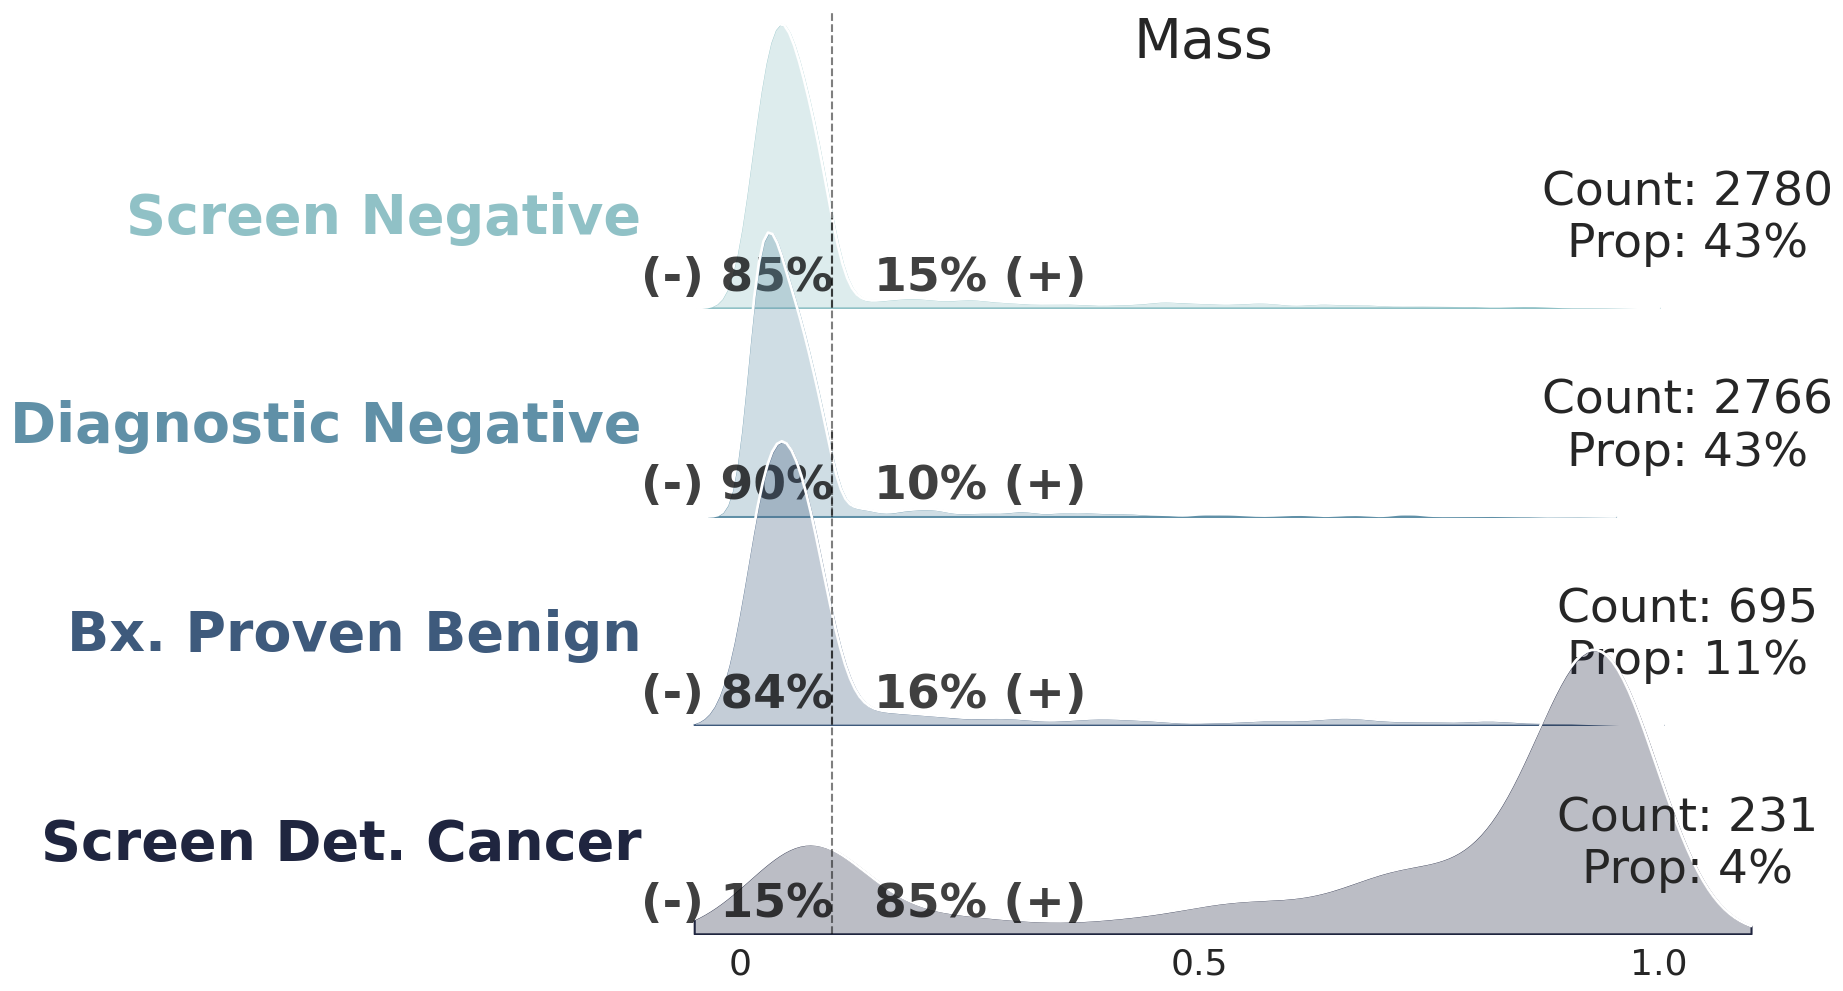

In [36]:
# Prepare the dataframes
label_type = 1

scr_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[0]]
dx_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[1]]
prv_ben_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[2]]
cancers_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[3]]

# Create a list of DataFrames and Labels
dataframes = [
    (scr_neg_df, outcome_categories_list[0]),
    (dx_neg_df, outcome_categories_list[1]),
    (prv_ben_df, outcome_categories_list[2]),
    (cancers_df, outcome_categories_list[3])
]

# Calculate the combined total entries across all dataframes
combined_total = sum(len(df) for df, _ in dataframes)

# Set theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the plot
fig, axes = plt.subplots(nrows=len(dataframes), figsize=(15, 12), sharex=True)

# Create a custom palette to match original style
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

# Iterate over DataFrames and Axes
for (df, label), ax, color in zip(dataframes, axes, pal):
    if len(df) > 0:
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, fill=True, alpha=0.3, linewidth=1.5, ax=ax, color=color, clip=(-0.05, 1.1))
        
        # Add a white line on top for style (mimicking ridge plot)
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, clip_on=False, color="w", lw=2, ax=ax, clip=(-0.05, 1.1))
        
        # Add a cutoff line at 0.1
        ax.axvline(x=0.1, color='black', linestyle='--', alpha=0.5)
        
        # Draw 25th, 50th, and 75th percentile lines
        p25 = np.percentile(df['score'], 25)
        p50 = np.percentile(df['score'], 50)
        p75 = np.percentile(df['score'], 75)
        y_min, y_max = ax.get_ylim()
        # ax.vlines(p25, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)
        # ax.vlines(p50, y_min, y_min + y_max*0.02, color='darkgray', linestyle='-', linewidth=1)
        # ax.vlines(p75, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)        
        
        # Remove y-axis labels and ticks
        ax.set_yticks([])
        ax.set_ylabel('')
        
        # Set x-ticks to 0, 0.5, 1.0 only and increase font size
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_xticklabels([0, 0.5, 1.0], fontsize=26)
        
        # Remove plot borders
        sns.despine(ax=ax, left=True, bottom=True)
        
        # Move title to the left
        ax.text(0, 0.3, label, fontweight="bold", color=color, ha="right", va="center",
                transform=ax.transAxes, fontsize=40)
        
        # Calculate counts and proportions
        total_count = len(df)
        total_proportion = total_count / combined_total if combined_total > 0 else 0
        below_threshold_count = len(df[df['score'] <= 0.1])
        above_threshold_count = len(df[df['score'] > 0.1])
        below_threshold_prop = below_threshold_count / total_count if total_count > 0 else 0
        above_threshold_prop = above_threshold_count / total_count if total_count > 0 else 0
        
        # Add annotations for counts and proportions
        ax.text(0.9, 0.3, f'Count: {total_count}\nProp: {total_proportion:.0%}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=34)

        # Annotate below and above threshold proportions
        ax.text(0, 0.1, f'(-) {below_threshold_prop:.0%}', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black', alpha=0.75)

        ax.text(0.2, 0.1, f'{above_threshold_prop:.0%} (+)', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black', alpha=0.75)
        
        # Add text labels for the percentile lines
        # ax.text(p25, y_min + y_max*0.4, "25%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p50, y_min + y_max*0.02, "50%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p75, y_min + y_max*0.4, "75%", ha='center', va='bottom', fontsize=10, color='black')
    
# Adjust layout to allow plots to overlap
fig.subplots_adjust(hspace=-0.3)

# Add a cutoff line across all plots
# plt.gcf().text(0.315, 0.825, "T (0.1)", ha='center', va='bottom', fontsize=34, color='gray')
fig.suptitle("Mass", fontsize=title_size_by_image_findings, fontweight='normal', y=0.875,)
plt.xlabel("")

# Show the combined plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "binary_mass_finding_by_outcome_characteristics.png", dpi=300, bbox_inches="tight")
plt.show()

#### 5.2 Asymmetry

In [37]:
# asymmetry == 1
lunit_mag_df_dedup_subset = lunit_mag_df_AB_dedup_acc_temp[lunit_mag_df_AB_dedup_acc_temp.exam_asymmetry == 1]
lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()

/tmp/ipykernel_2235176/4251025474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()


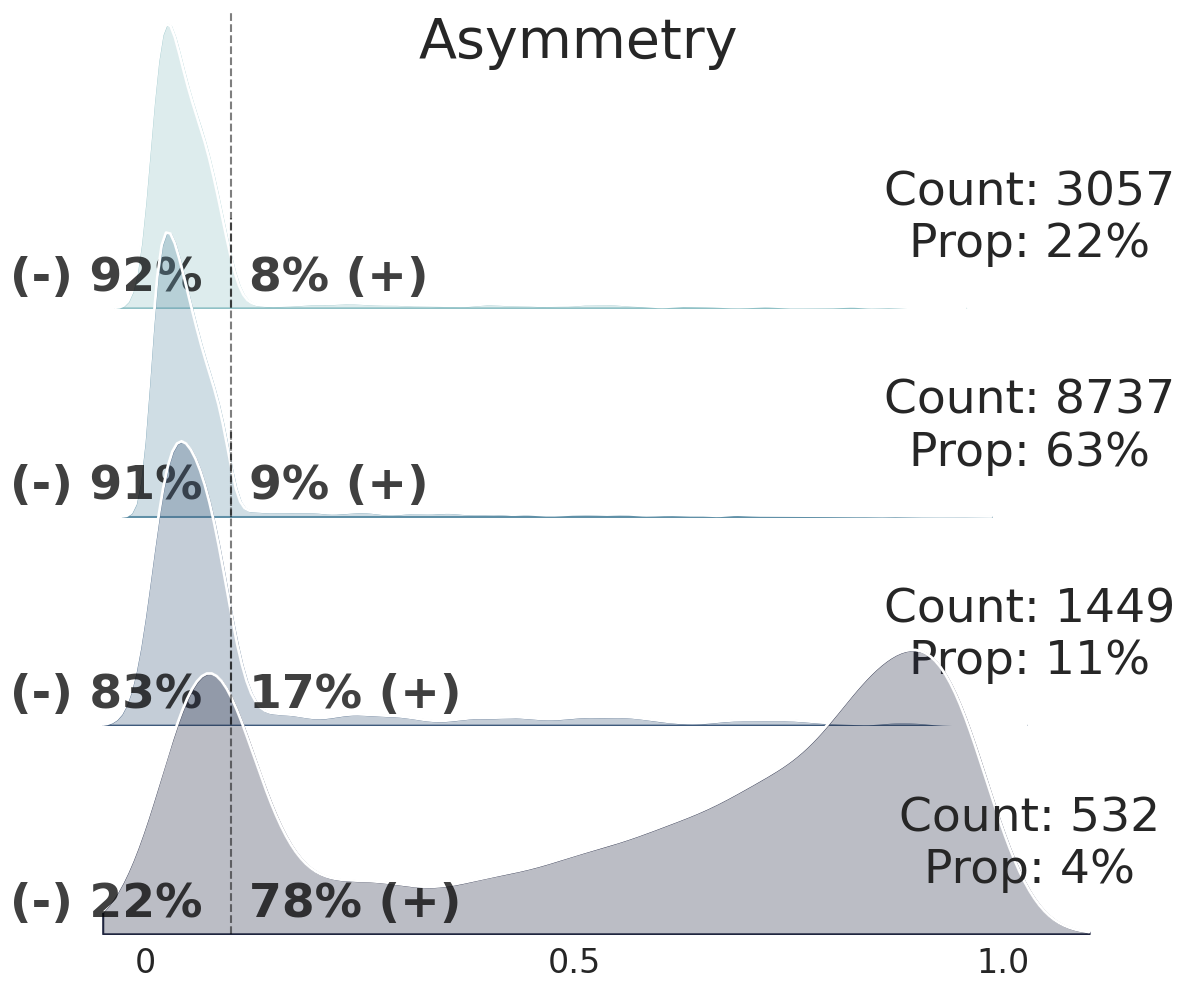

In [38]:
# Prepare the dataframes
label_type = 1

scr_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[0]]
dx_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[1]]
prv_ben_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[2]]
cancers_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[3]]

# Create a list of DataFrames and Labels
dataframes = [
    (scr_neg_df, outcome_categories_list[0]),
    (dx_neg_df, outcome_categories_list[1]),
    (prv_ben_df, outcome_categories_list[2]),
    (cancers_df, outcome_categories_list[3])
]

# Calculate the combined total entries across all dataframes
combined_total = sum(len(df) for df, _ in dataframes)

# Set theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the plot
fig, axes = plt.subplots(nrows=len(dataframes), figsize=(14, 12), sharex=True)

# Create a custom palette to match original style
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

# Iterate over DataFrames and Axes
for (df, label), ax, color in zip(dataframes, axes, pal):
    if len(df) > 0:
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, fill=True, alpha=0.3, linewidth=1.5, ax=ax, color=color, clip=(-0.05, 1.1))
        
        # Add a white line on top for style (mimicking ridge plot)
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, clip_on=False, color="w", lw=2, ax=ax, clip=(-0.05, 1.1))
        
        # Add a cutoff line at 0.1
        ax.axvline(x=0.1, color='black', linestyle='--', alpha=0.5)
        
        # Draw 25th, 50th, and 75th percentile lines
        p25 = np.percentile(df['score'], 25)
        p50 = np.percentile(df['score'], 50)
        p75 = np.percentile(df['score'], 75)
        y_min, y_max = ax.get_ylim()
        # ax.vlines(p25, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)
        # ax.vlines(p50, y_min, y_min + y_max*0.4, color='darkgray', linestyle='-', linewidth=1)
        # ax.vlines(p75, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)        
        
        # Remove y-axis labels and ticks
        ax.set_yticks([])
        ax.set_ylabel('')
        
        # Set x-ticks to 0, 0.5, 1.0 only and increase font size
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_xticklabels([0, 0.5, 1.0], fontsize=24)
        
        # Remove plot borders
        sns.despine(ax=ax, left=True, bottom=True)
        
        # Move title to the left and make vertical
        # ax.text(-0.05, 0.3, label, fontweight="bold", color=color, ha="right", va="center",
                # transform=ax.transAxes, rotation='vertical', fontsize=14)
        
        # Calculate counts and proportions
        total_count = len(df)
        total_proportion = total_count / combined_total if combined_total > 0 else 0
        below_threshold_count = len(df[df['score'] <= 0.1])
        above_threshold_count = len(df[df['score'] > 0.1])
        below_threshold_prop = below_threshold_count / total_count if total_count > 0 else 0
        above_threshold_prop = above_threshold_count / total_count if total_count > 0 else 0
        
        # Add annotations for counts and proportions
        ax.text(0.9, 0.3, f'Count: {total_count}\nProp: {total_proportion:.0%}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=34)

        # Annotate below and above threshold proportions
        ax.text(-0.04, 0.1, f'(-) {below_threshold_prop:.0%}', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black', alpha=0.75)

        ax.text(0.18, 0.1, f'{above_threshold_prop:.0%} (+)', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black', alpha=0.75)
        
        # Add text labels for the percentile lines
        # ax.text(p25, y_min + y_max*0.4, "25%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p50, y_min + y_max*0.4, "50%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p75, y_min + y_max*0.4, "75%", ha='center', va='bottom', fontsize=10, color='black')
    
# Adjust layout to allow plots to overlap
fig.subplots_adjust(hspace=-0.3)

# Add a cutoff line across all plots
# plt.gcf().text(0.315, 0.85, "T (0.1)", ha='center', va='bottom', fontsize=34, color='gray')
fig.suptitle("Asymmetry", fontsize=title_size_by_image_findings, fontweight='normal', y=0.875,)
plt.xlabel("")

# Show the combined plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "binary_asymmetry_finding_by_outcome_characteristics.png", dpi=300, bbox_inches="tight")
plt.show()

#### 5.3 Arch Distortion

In [39]:
# arch distortion == 1
lunit_mag_df_dedup_subset = lunit_mag_df_AB_dedup_acc_temp[lunit_mag_df_AB_dedup_acc_temp.exam_arch_distortion == 1]
lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()

/tmp/ipykernel_2235176/815646513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()


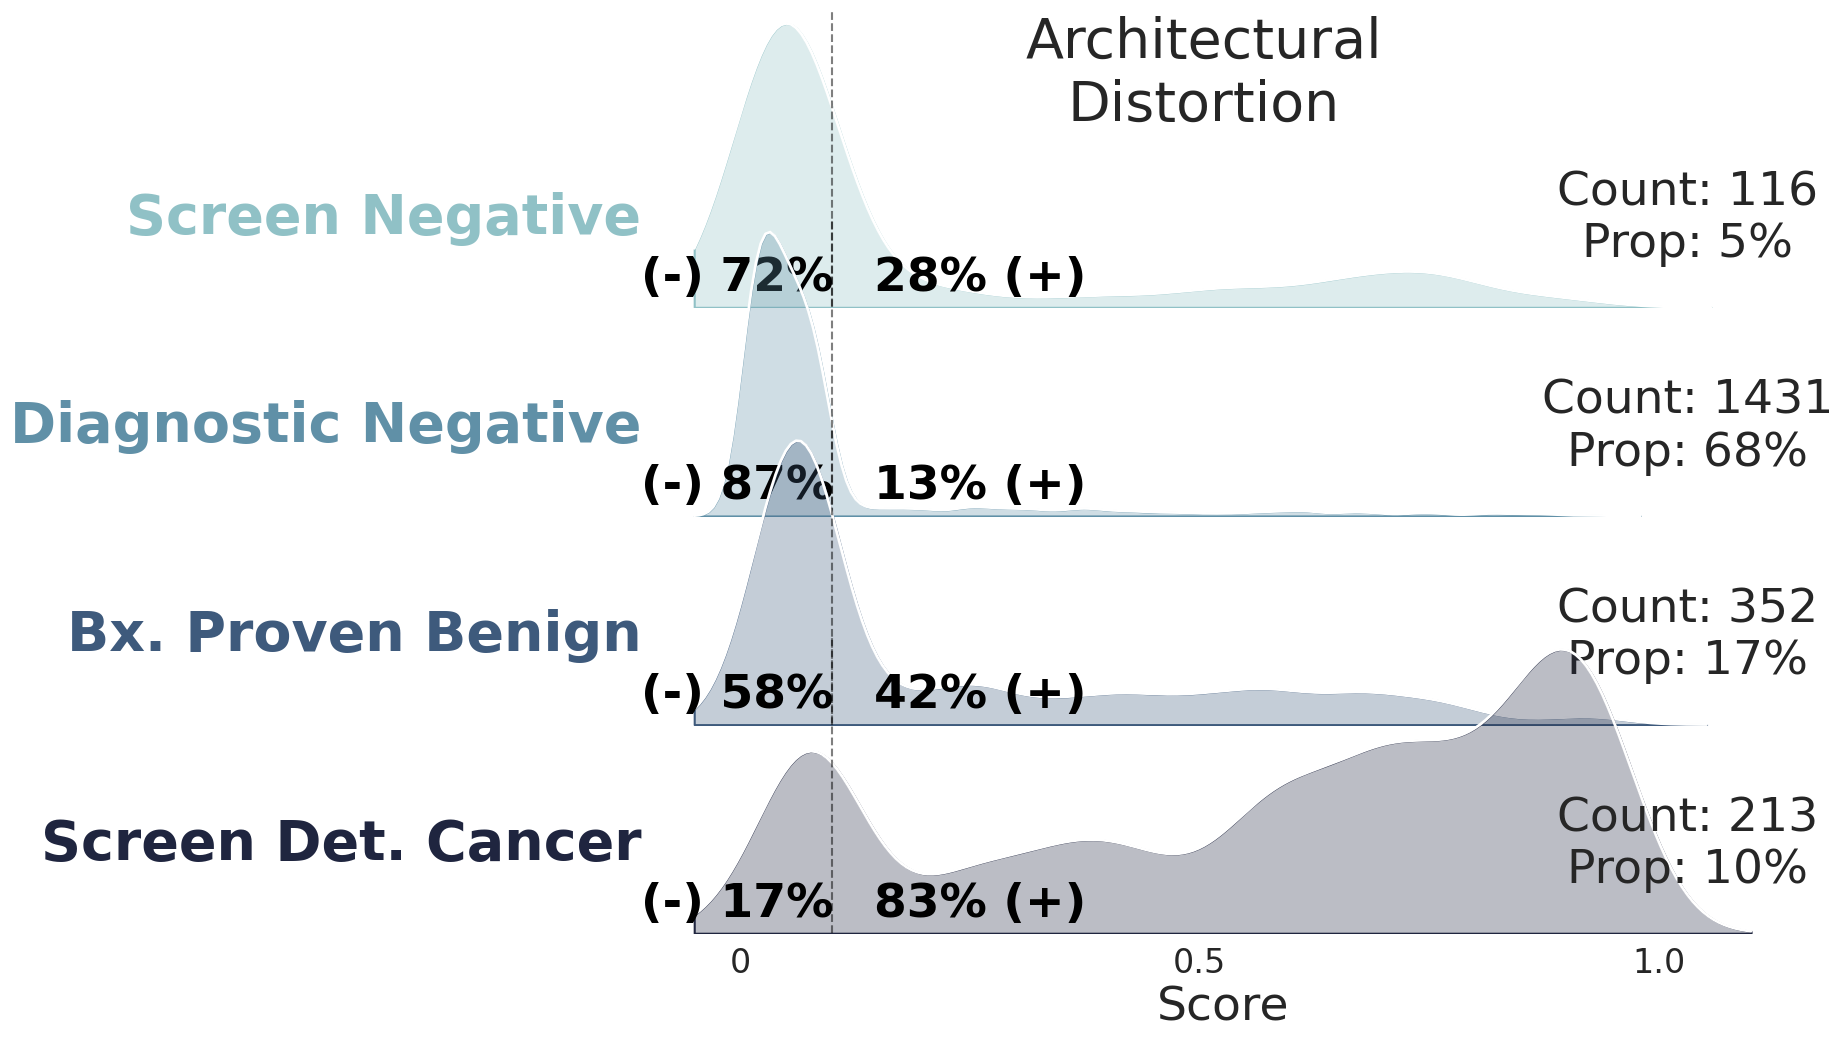

In [40]:
# Prepare the dataframes
label_type = 1

scr_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[0]]
dx_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[1]]
prv_ben_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[2]]
cancers_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[3]]

# Create a list of DataFrames and Labels
dataframes = [
    (scr_neg_df, outcome_categories_list[0]),
    (dx_neg_df, outcome_categories_list[1]),
    (prv_ben_df, outcome_categories_list[2]),
    (cancers_df, outcome_categories_list[3])
]

# Calculate the combined total entries across all dataframes
combined_total = sum(len(df) for df, _ in dataframes)

# Set theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the plot
fig, axes = plt.subplots(nrows=len(dataframes), figsize=(15, 12), sharex=True)

# Create a custom palette to match original style
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

# Iterate over DataFrames and Axes
for (df, label), ax, color in zip(dataframes, axes, pal):
    if len(df) > 0:
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, fill=True, alpha=0.3, linewidth=1.5, ax=ax, color=color, clip=(-0.05, 1.1))
        
        # Add a white line on top for style (mimicking ridge plot)
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, clip_on=False, color="w", lw=2, ax=ax, clip=(-0.05, 1.1))
        
        # Add a cutoff line at 0.1
        ax.axvline(x=0.1, color='black', linestyle='--', alpha=0.5)
        
        # Draw 25th, 50th, and 75th percentile lines
        p25 = np.percentile(df['score'], 25)
        p50 = np.percentile(df['score'], 50)
        p75 = np.percentile(df['score'], 75)
        y_min, y_max = ax.get_ylim()
        # ax.vlines(p25, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)
        # ax.vlines(p50, y_min, y_min + y_max*0.02, color='darkgray', linestyle='-', linewidth=1)
        # ax.vlines(p75, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)        
        
        # Remove y-axis labels and ticks
        ax.set_yticks([])
        ax.set_ylabel('')
        
        # Set x-ticks to 0, 0.5, 1.0 only and increase font size
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_xticklabels([0, 0.5, 1.0], fontsize=24)
        
        # Remove plot borders
        sns.despine(ax=ax, left=True, bottom=True)
        
        # Move title to the left
        ax.text(0, 0.3, label, fontweight="bold", color=color, ha="right", va="center",
                transform=ax.transAxes, fontsize=40)
        
        # Calculate counts and proportions
        total_count = len(df)
        total_proportion = total_count / combined_total if combined_total > 0 else 0
        below_threshold_count = len(df[df['score'] <= 0.1])
        above_threshold_count = len(df[df['score'] > 0.1])
        below_threshold_prop = below_threshold_count / total_count if total_count > 0 else 0
        above_threshold_prop = above_threshold_count / total_count if total_count > 0 else 0
        
        # Add annotations for counts and proportions
        ax.text(0.9, 0.3, f'Count: {total_count}\nProp: {total_proportion:.0%}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=34)

        # Annotate below and above threshold proportions
        ax.text(0, 0.1, f'(-) {below_threshold_prop:.0%}', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black')

        ax.text(0.2, 0.1, f'{above_threshold_prop:.0%} (+)', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black')
        
        # Add text labels for the percentile lines
        # ax.text(p25, y_min + y_max*0.4, "25%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p50, y_min + y_max*0.02, "50%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p75, y_min + y_max*0.4, "75%", ha='center', va='bottom', fontsize=10, color='black')
    
# Adjust layout to allow plots to overlap
fig.subplots_adjust(hspace=-0.3)

# Add a cutoff line across all plots
# plt.gcf().text(0.3, 0.85, "T (0.1)", ha='center', va='bottom', fontsize=34, color='gray')
fig.suptitle("Architectural\nDistortion", fontsize=title_size_by_image_findings, fontweight='normal', y=0.875,)
plt.xlabel("Score", fontsize=34)

# Show the combined plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "binary_arch_distortion_finding_by_outcome_characteristics.png", dpi=300, bbox_inches="tight")
plt.show()

#### 5.4 Calcification

In [41]:
# calcification == 1
lunit_mag_df_dedup_subset = lunit_mag_df_AB_dedup_acc_temp[lunit_mag_df_AB_dedup_acc_temp.exam_calcification == 1]
lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()

/tmp/ipykernel_2235176/2084377600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lunit_mag_df_dedup_subset['outcome_type'] = lunit_mag_df_dedup_subset['outcome_type'].cat.remove_unused_categories()


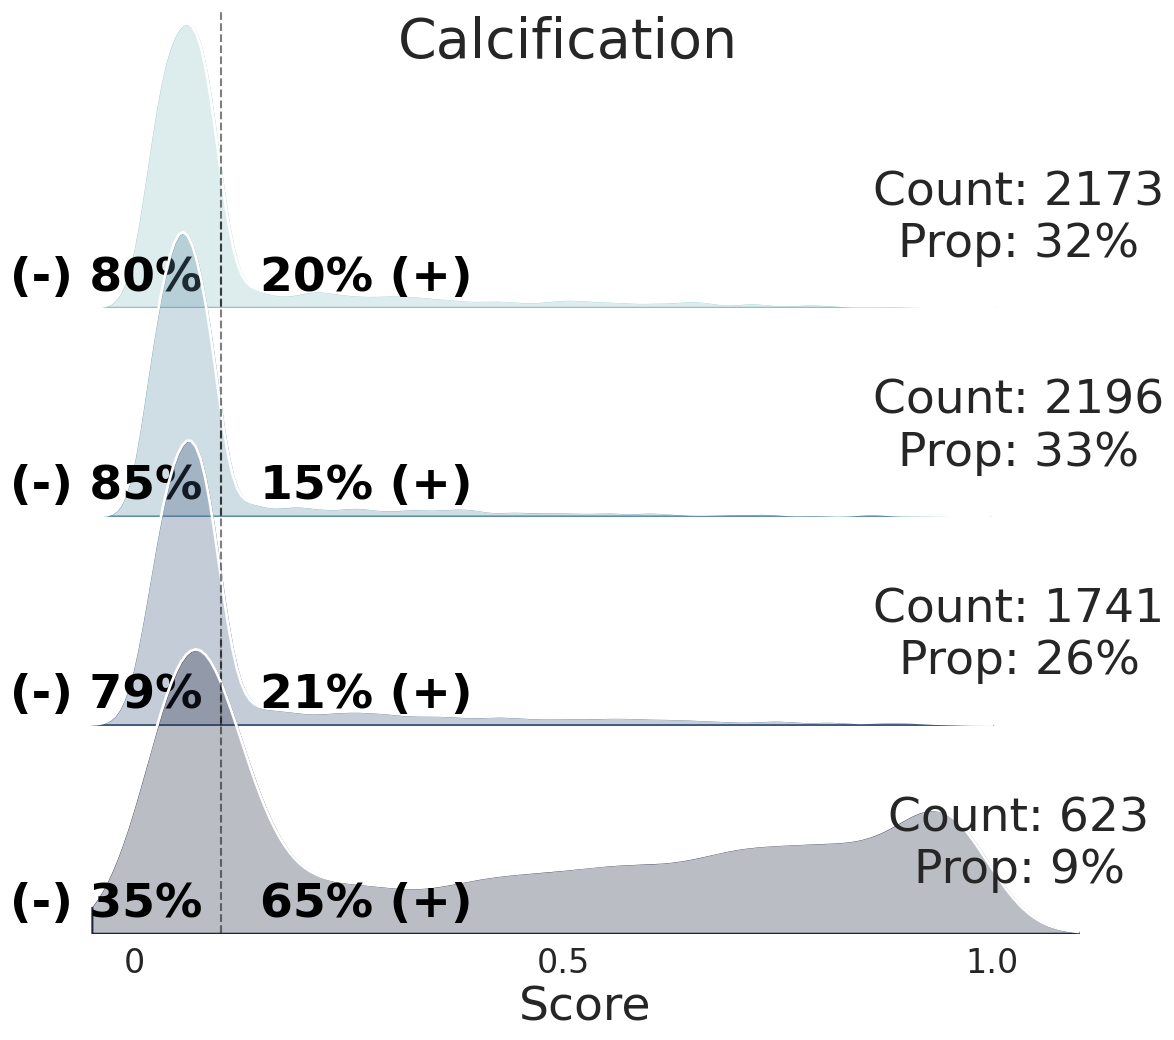

In [42]:
# Prepare the dataframes
label_type = 1

scr_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[0]]
dx_neg_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[1]]
prv_ben_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[2]]
cancers_df = lunit_mag_df_dedup_subset[lunit_mag_df_dedup_subset.outcome_type == outcome_categories_list[3]]

# Create a list of DataFrames and Labels
dataframes = [
    (scr_neg_df, outcome_categories_list[0]),
    (dx_neg_df, outcome_categories_list[1]),
    (prv_ben_df, outcome_categories_list[2]),
    (cancers_df, outcome_categories_list[3])
]

# Calculate the combined total entries across all dataframes
combined_total = sum(len(df) for df, _ in dataframes)

# Set theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the plot
fig, axes = plt.subplots(nrows=len(dataframes), figsize=(14, 12), sharex=True)

# Create a custom palette to match original style
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)

# Iterate over DataFrames and Axes
for (df, label), ax, color in zip(dataframes, axes, pal):
    if len(df) > 0:
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, fill=True, alpha=0.3, linewidth=1.5, ax=ax, color=color, clip=(-0.05, 1.1))
        
        # Add a white line on top for style (mimicking ridge plot)
        sns.kdeplot(data=df, x='score', bw_adjust=0.5, clip_on=False, color="w", lw=2, ax=ax, clip=(-0.05, 1.1))
        
        # Add a cutoff line at 0.1
        ax.axvline(x=0.1, color='black', linestyle='--', alpha=0.5)
        
        # Draw 25th, 50th, and 75th percentile lines
        p25 = np.percentile(df['score'], 25)
        p50 = np.percentile(df['score'], 50)
        p75 = np.percentile(df['score'], 75)
        y_min, y_max = ax.get_ylim()
        # ax.vlines(p25, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)
        # ax.vlines(p50, y_min, y_min + y_max*0.4, color='darkgray', linestyle='-', linewidth=1)
        # ax.vlines(p75, y_min, y_min + y_max*0.4, color='darkgray', linestyle='--', linewidth=1.5)        
        
        # Remove y-axis labels and ticks
        ax.set_yticks([])
        ax.set_ylabel('')
        
        # Set x-ticks to 0, 0.5, 1.0 only and increase font size
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_xticklabels([0, 0.5, 1.0], fontsize=24)
        
        # Remove plot borders
        sns.despine(ax=ax, left=True, bottom=True)
        
        # Move title to the left and make vertical
        # ax.text(-0.05, 0.3, label, fontweight="bold", color=color, ha="right", va="center",
                # transform=ax.transAxes, rotation='vertical', fontsize=14)
        
        # Calculate counts and proportions
        total_count = len(df)
        total_proportion = total_count / combined_total if combined_total > 0 else 0
        below_threshold_count = len(df[df['score'] <= 0.1])
        above_threshold_count = len(df[df['score'] > 0.1])
        below_threshold_prop = below_threshold_count / total_count if total_count > 0 else 0
        above_threshold_prop = above_threshold_count / total_count if total_count > 0 else 0
        
        # Add annotations for counts and proportions
        ax.text(0.9, 0.3, f'Count: {total_count}\nProp: {total_proportion:.0%}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=34)

        # Annotate below and above threshold proportions
        ax.text(-0.03, 0.1, f'(-) {below_threshold_prop:.0%}', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black')

        ax.text(0.2, 0.1, f'{above_threshold_prop:.0%} (+)', 
                ha='left', va='center', transform=ax.transAxes, fontsize=34, fontweight='bold', color='black')
        
        # Add text labels for the percentile lines
        # ax.text(p25, y_min + y_max*0.4, "25%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p50, y_min + y_max*0.4, "50%", ha='center', va='bottom', fontsize=10, color='black')
        # ax.text(p75, y_min + y_max*0.4, "75%", ha='center', va='bottom', fontsize=10, color='black')
    
# Adjust layout to allow plots to overlap
fig.subplots_adjust(hspace=-0.3)

# Add a cutoff line across all plots
# plt.gcf().text(0.31, 0.85, "T (0.1)", ha='center', va='bottom', fontsize=34, color='gray')
fig.suptitle("Calcification", fontsize=title_size_by_image_findings, fontweight='normal', y=0.875,)

plt.xlabel("Score", fontsize=34)

# Show the combined plot
if WRITE_OUTPUT:
    plt.savefig(basepath_for_images + "binary_calc_finding_by_outcome_characteristics.png", dpi=300, bbox_inches="tight")
plt.show()

#### 5.5 Stitch Finding Characteristics Figures

In [43]:
image_paths = [basepath_for_images + "binary_mass_finding_by_outcome_characteristics.png", 
               basepath_for_images + "binary_asymmetry_finding_by_outcome_characteristics.png", 
               basepath_for_images + "binary_arch_distortion_finding_by_outcome_characteristics.png", 
               basepath_for_images + "binary_calc_finding_by_outcome_characteristics.png"]  # Replace with actual file paths

images = [Image.open(img) for img in image_paths]

images[0] = images[0].resize((images[2].width, images[2].height))
images[1] = images[1].resize((images[3].width, images[2].height))
images[3] = images[3].resize((images[3].width, images[2].height))


img_width, img_height = images[0].size
# new_width = img_width * 2  # Two images per row
# new_height = img_height * 2  # Two rows

new_width = images[0].size[0] + images[1].size[0]
new_height = images[0].size[1] + images[1].size[1]

# Create a blank image with the right size
stitched_image = Image.new("RGB", (new_width, new_height))

# Paste images into the new blank image
positions = [(0, 0), (img_width, 0), (0, img_height), (img_width, img_height)]
for img, pos in zip(images, positions):
    stitched_image.paste(img, pos)

if WRITE_OUTPUT:
    stitched_image.save(basepath_for_images + "/binary_findings_by_outcome_characteristics.png")
stitched_image.show()

In [44]:
stitched_image

Error: no "view" mailcap rules found for type "image/png"
/bin/xdg-open: 882: www-browser: not found
/bin/xdg-open: 882: links2: not found
/bin/xdg-open: 882: elinks: not found
/bin/xdg-open: 882: links: not found
/bin/xdg-open: 882: lynx: not found
/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpu9s5g47z.PNG'


---

### 6. False Negatives - Failure Analyses

In [45]:
# Total
lunit_mag_df_AB_dedup[(lunit_mag_df_AB_dedup.exam_pathology.isin([non_inv_cancer_n, 'Invasive\nCancer']))].groupby("exam_pathology")[["mass","asymmetry","arch_distortion","calcification"]].sum()

mass  asymmetry  arch_distortion  calcification
exam_pathology                                                   
DCIS                30         89               23            407
Invasive\nCancer   227        502              201            259

In [46]:
# False negatives
lunit_mag_df_AB_dedup[(lunit_mag_df_AB_dedup.exam_pathology.isin([non_inv_cancer_n, 'Invasive\nCancer'])) & (lunit_mag_df_AB_dedup.score<=0.1)].groupby("exam_pathology")[["mass","asymmetry","arch_distortion","calcification"]].sum()

mass  asymmetry  arch_distortion  calcification
exam_pathology                                                   
DCIS                15         42                9            179
Invasive\nCancer    22         88               27             44

In [47]:
lunit_mag_df_AB_dedup[(lunit_mag_df_AB_dedup.exam_pathology.isin([non_inv_cancer_n, 'Invasive\nCancer'])) & (lunit_mag_df_AB_dedup.score<=0.1)][['acc_anon', 'exam_pathology']].drop_duplicates()['exam_pathology'].value_counts()

exam_pathology
DCIS                206
Invasive\nCancer    160
Name: count, dtype: int64

---

### Misc : Finding Permutations; BIRADS 0 Distribution

In [48]:
# Permutations of Findings 
mag_df[mag_df['path_severity']<=1][['race','ethnicity','tissueden','path_severity','massshape','massmargin','calcdistri','calcfind']].drop_duplicates().shape

(420, 8)

In [49]:
### Number of exams with one BIRADS 0
### Number of exams with >1 BIRADS 0
temp_asses = lunit_mag_df_AB_dedup[lunit_mag_df_AB_dedup['asses'] == 'A'][['acc_anon', 'numfind', 'asses']].drop_duplicates()
temp_asses = temp_asses.acc_anon.value_counts().reset_index()
temp_asses[temp_asses['count'] == 1].shape, temp_asses[temp_asses['count'] > 1].shape

((17533, 2), (3319, 2))

In [50]:
# In proportions
(temp_asses[temp_asses['count'] > 1].shape[0])/temp_asses.shape[0], (temp_asses[temp_asses['count'] == 1].shape[0])/temp_asses.shape[0]

(0.15916938423172838, 0.8408306157682717)

---